In [31]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
import glob
from astropy.wcs import WCS
from astropy.table import Table
import astropy
import Modified_Constrained_Diffusion
import importlib

In [32]:
# importlib.reload(Modified_Constrained_Diffusion)

# cdd_dir = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource"

# label_folder_path = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource"
# base_dir = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data"
# label = "ngc0628_F770W"
# custom_path = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource"

# Modified_Constrained_Diffusion.decompose(label_folder_path = label_folder_path, base_dir = base_dir, label = label, distance_mpc=9.84, res=.27, pixscale = 5.24, min_power=0, max_power=2, pix = True, custom_path = custom_path)

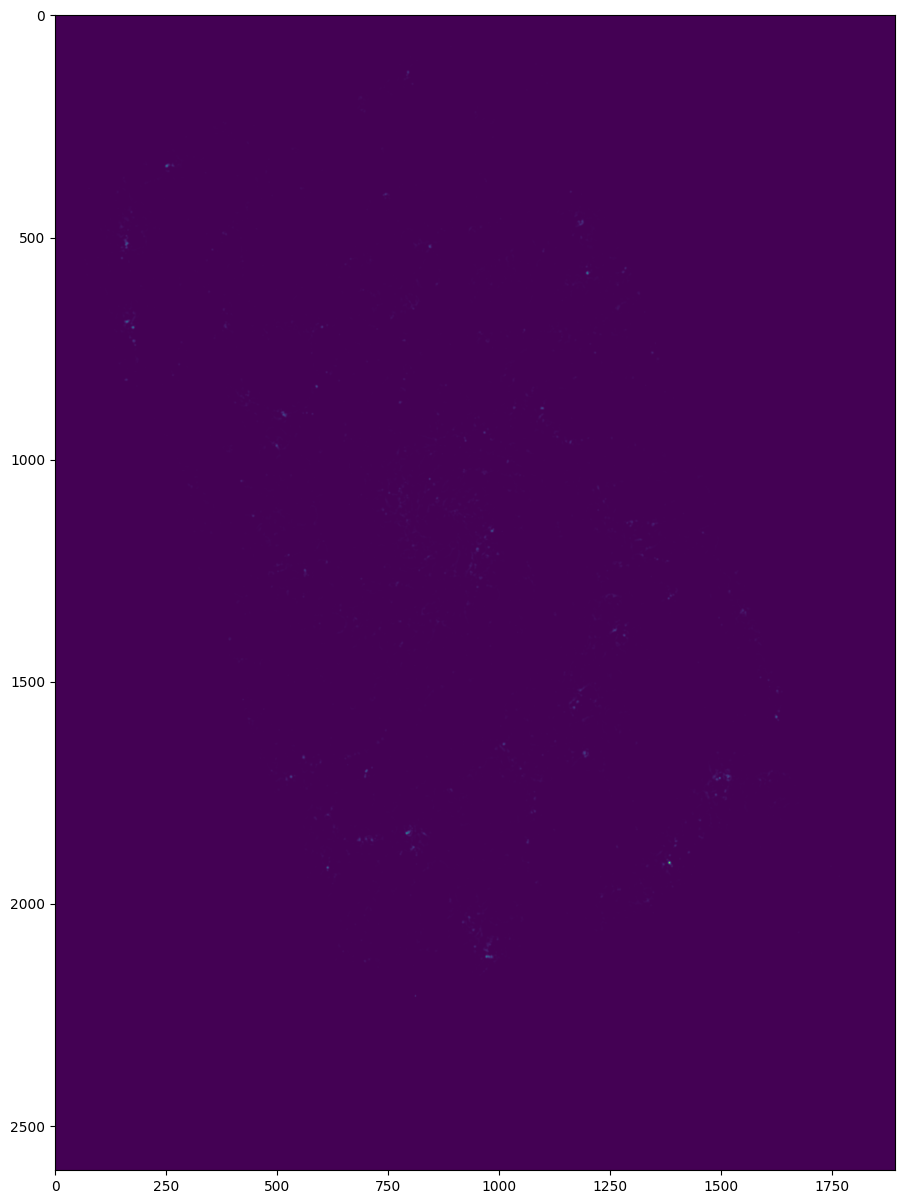

16573


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


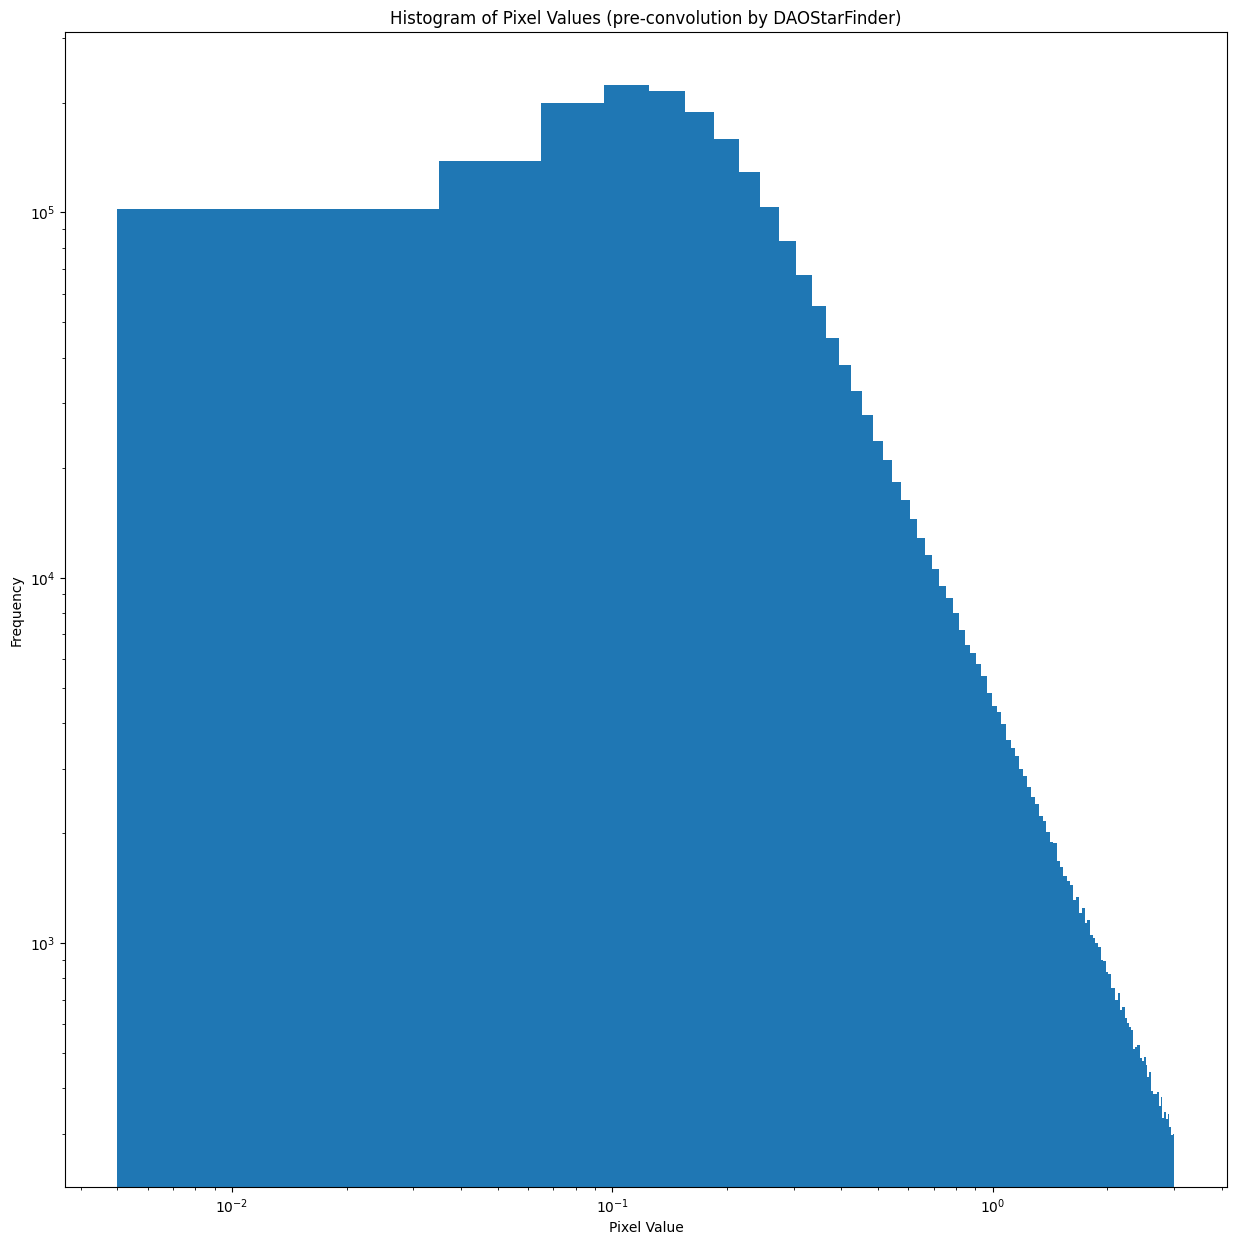

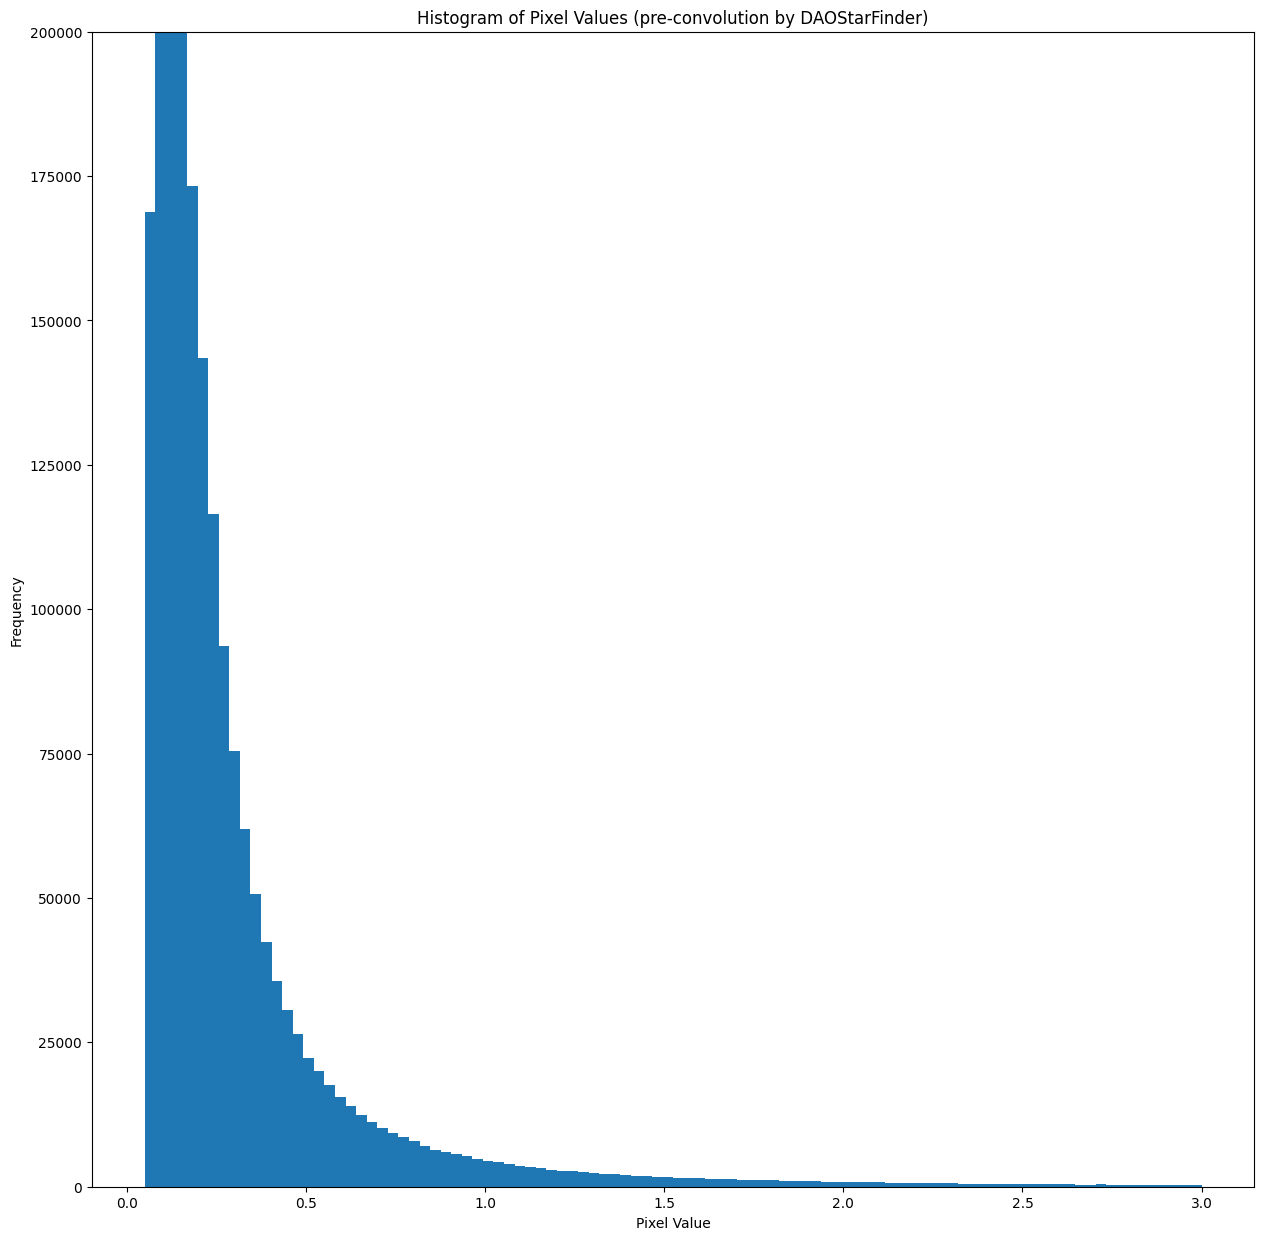

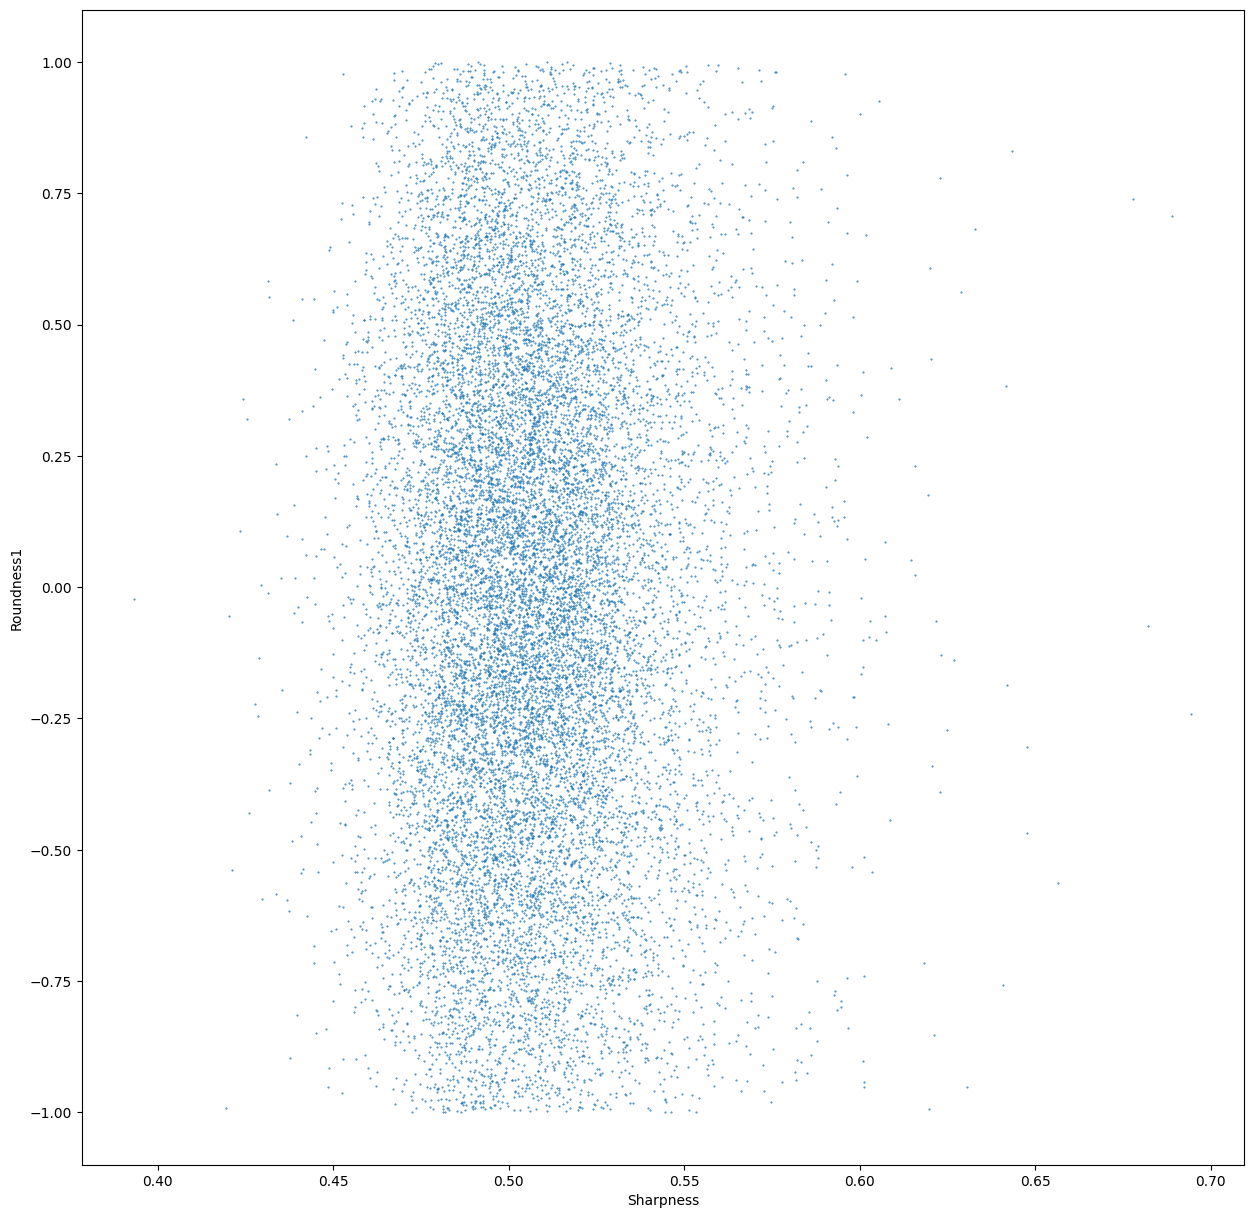

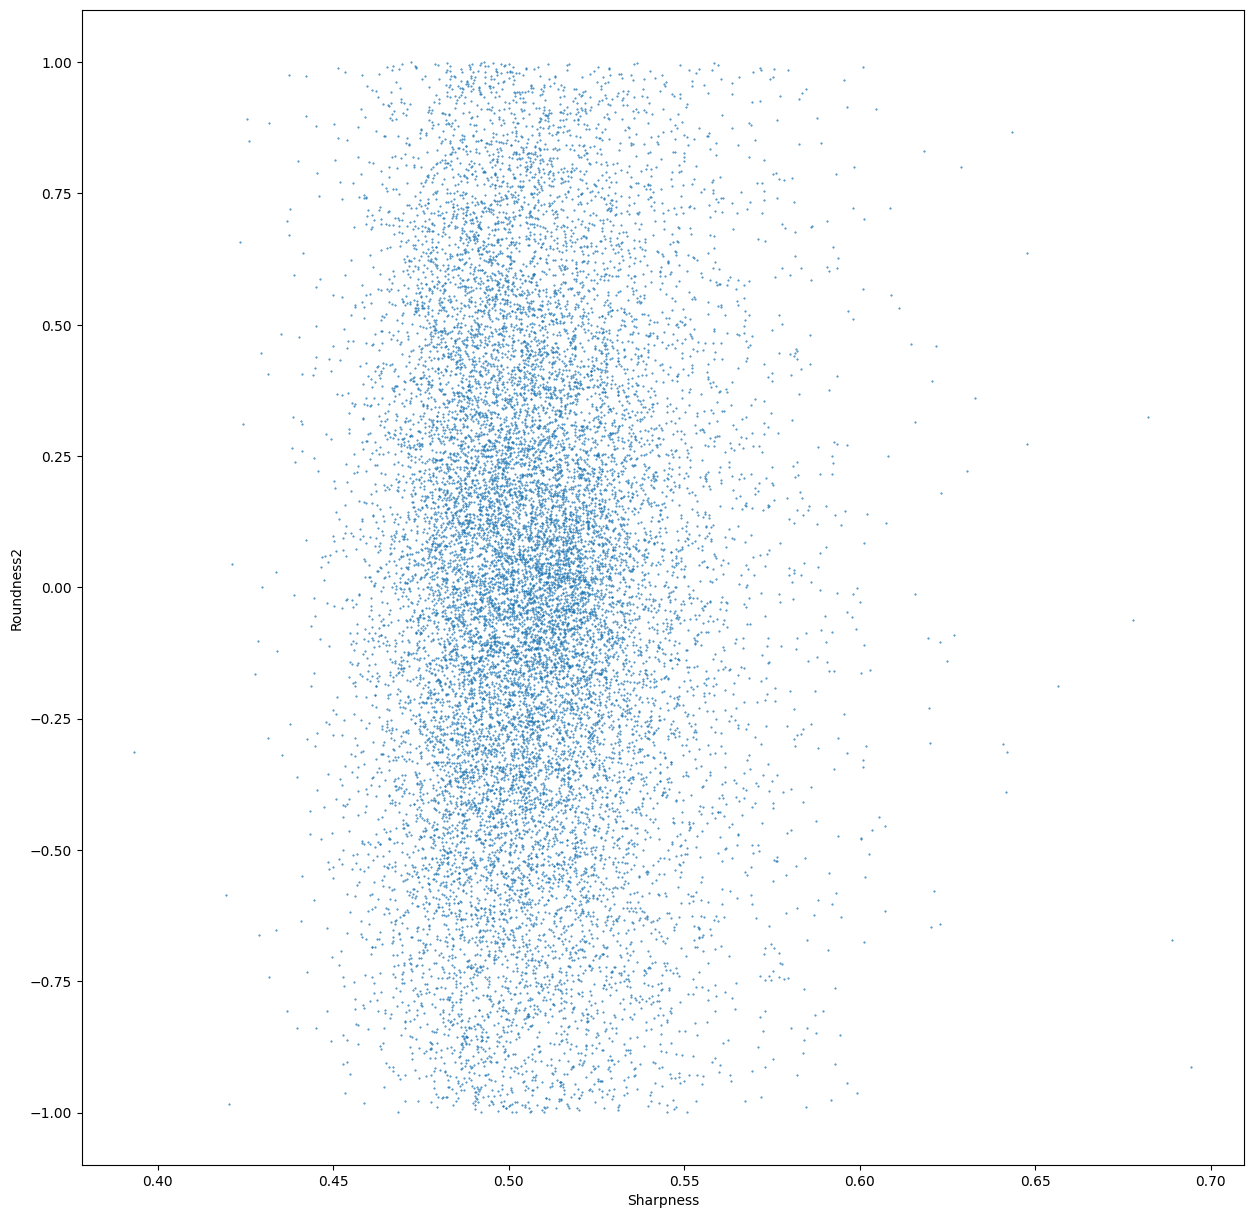

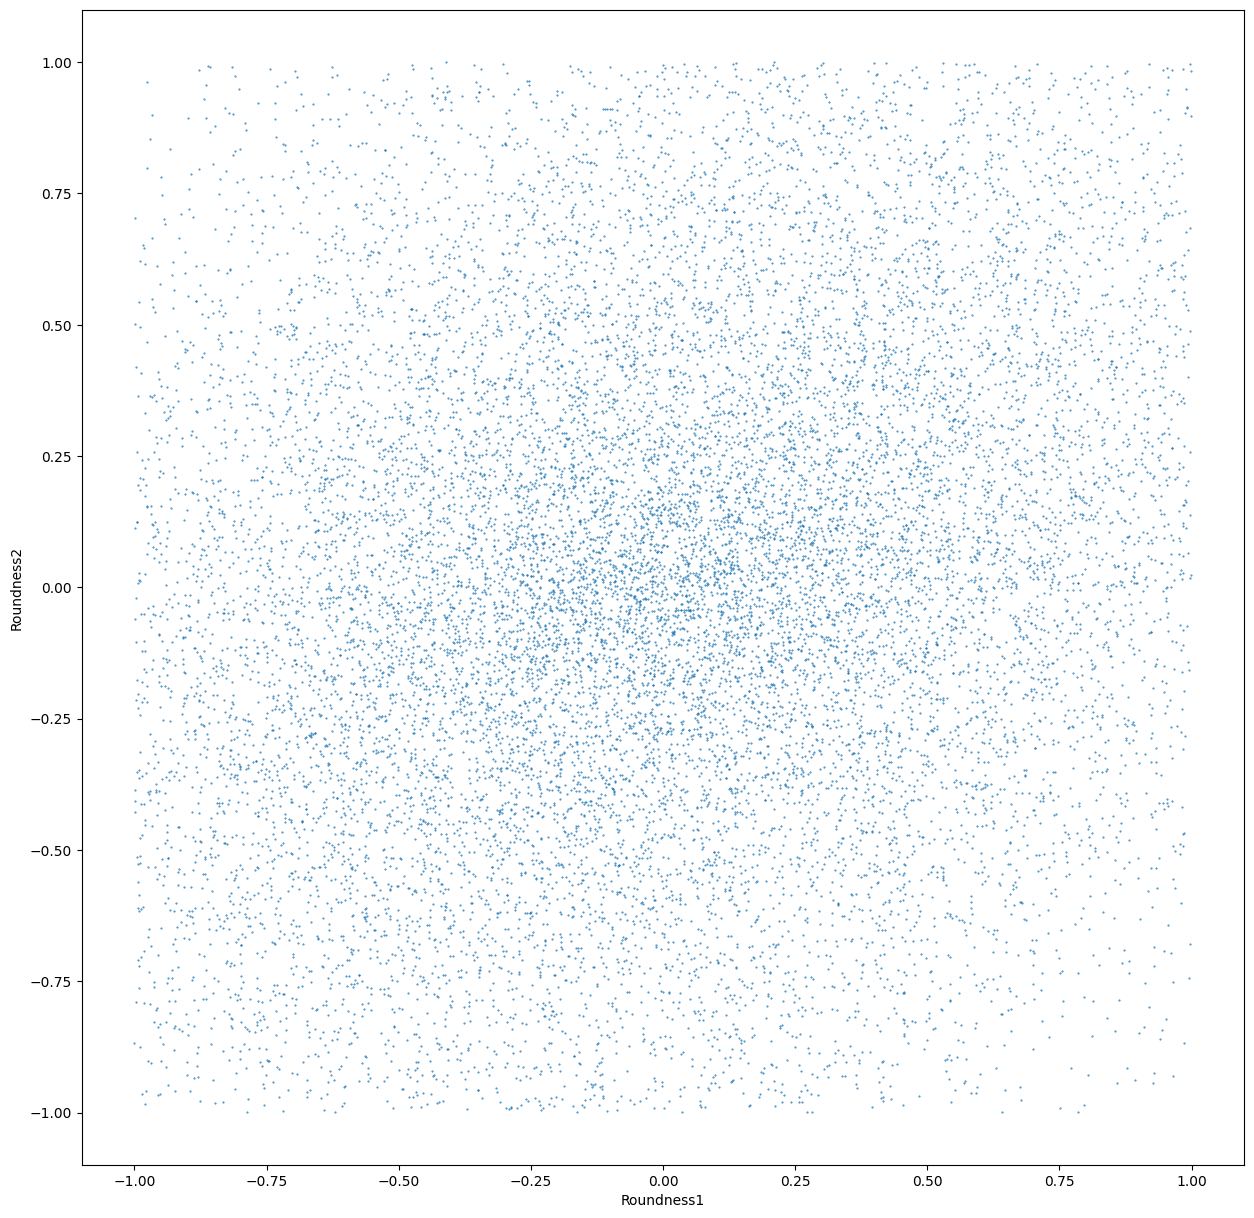

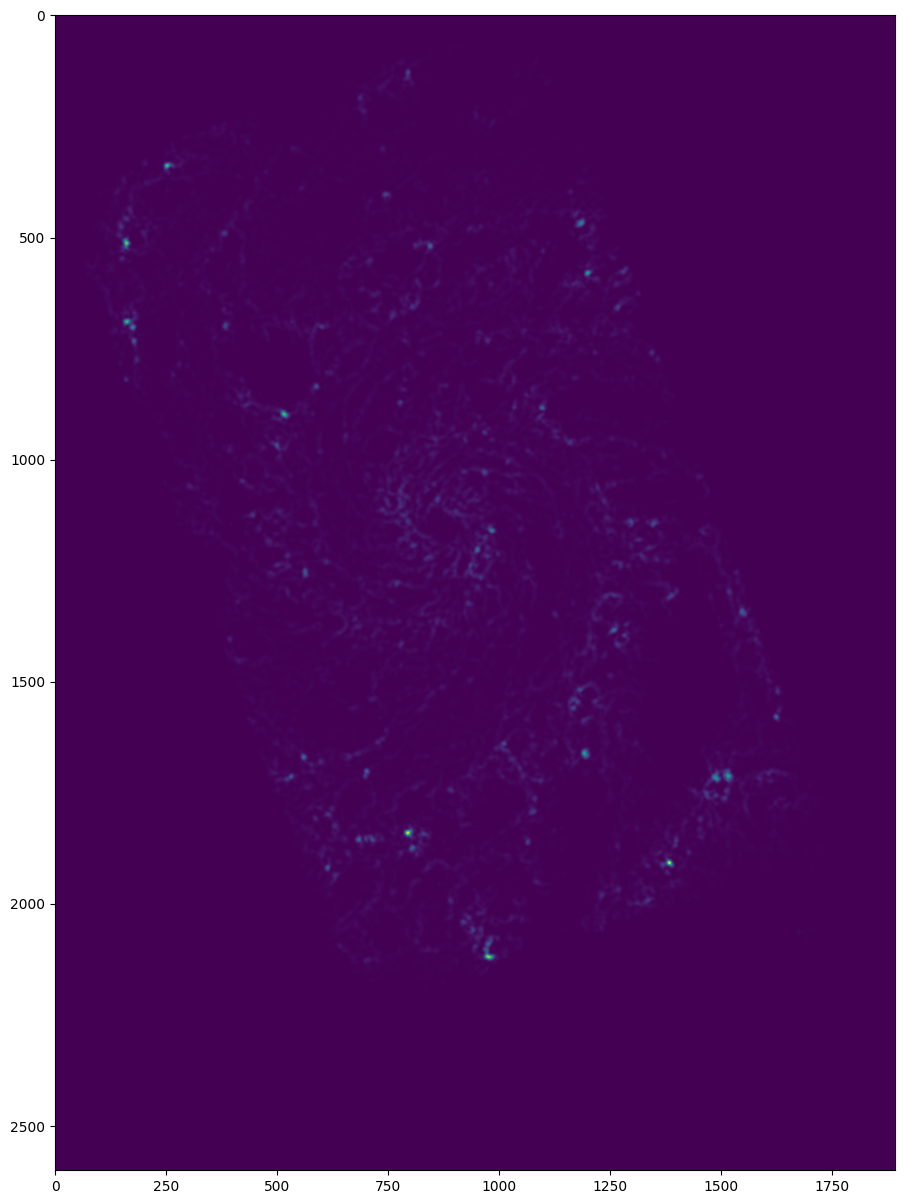

141


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


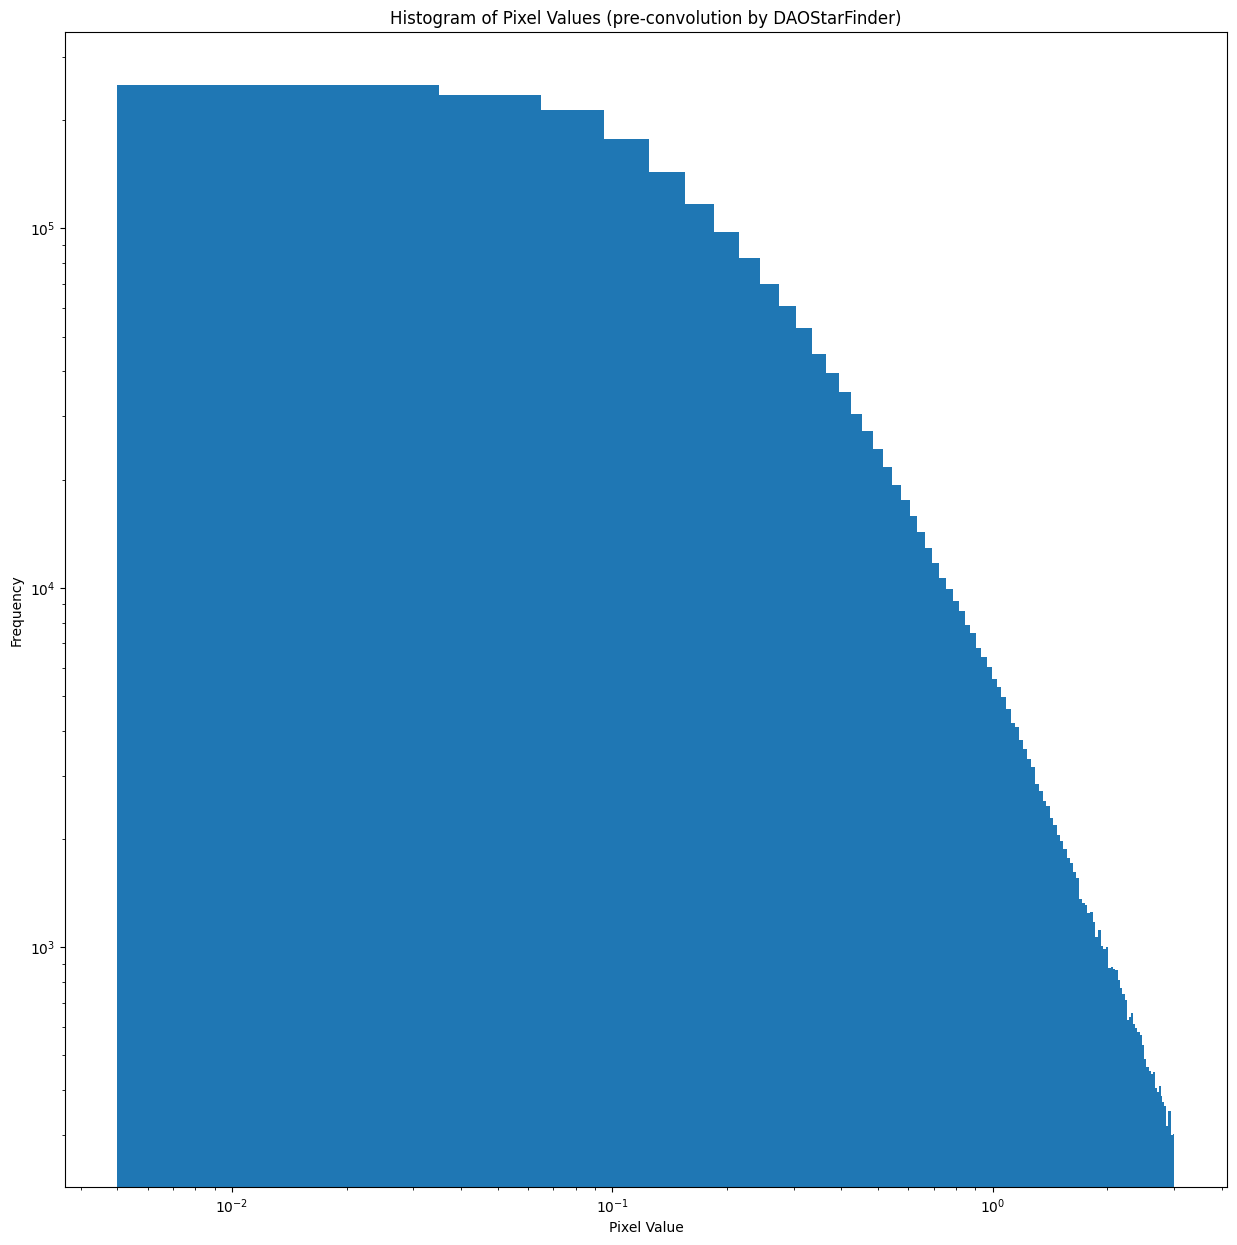

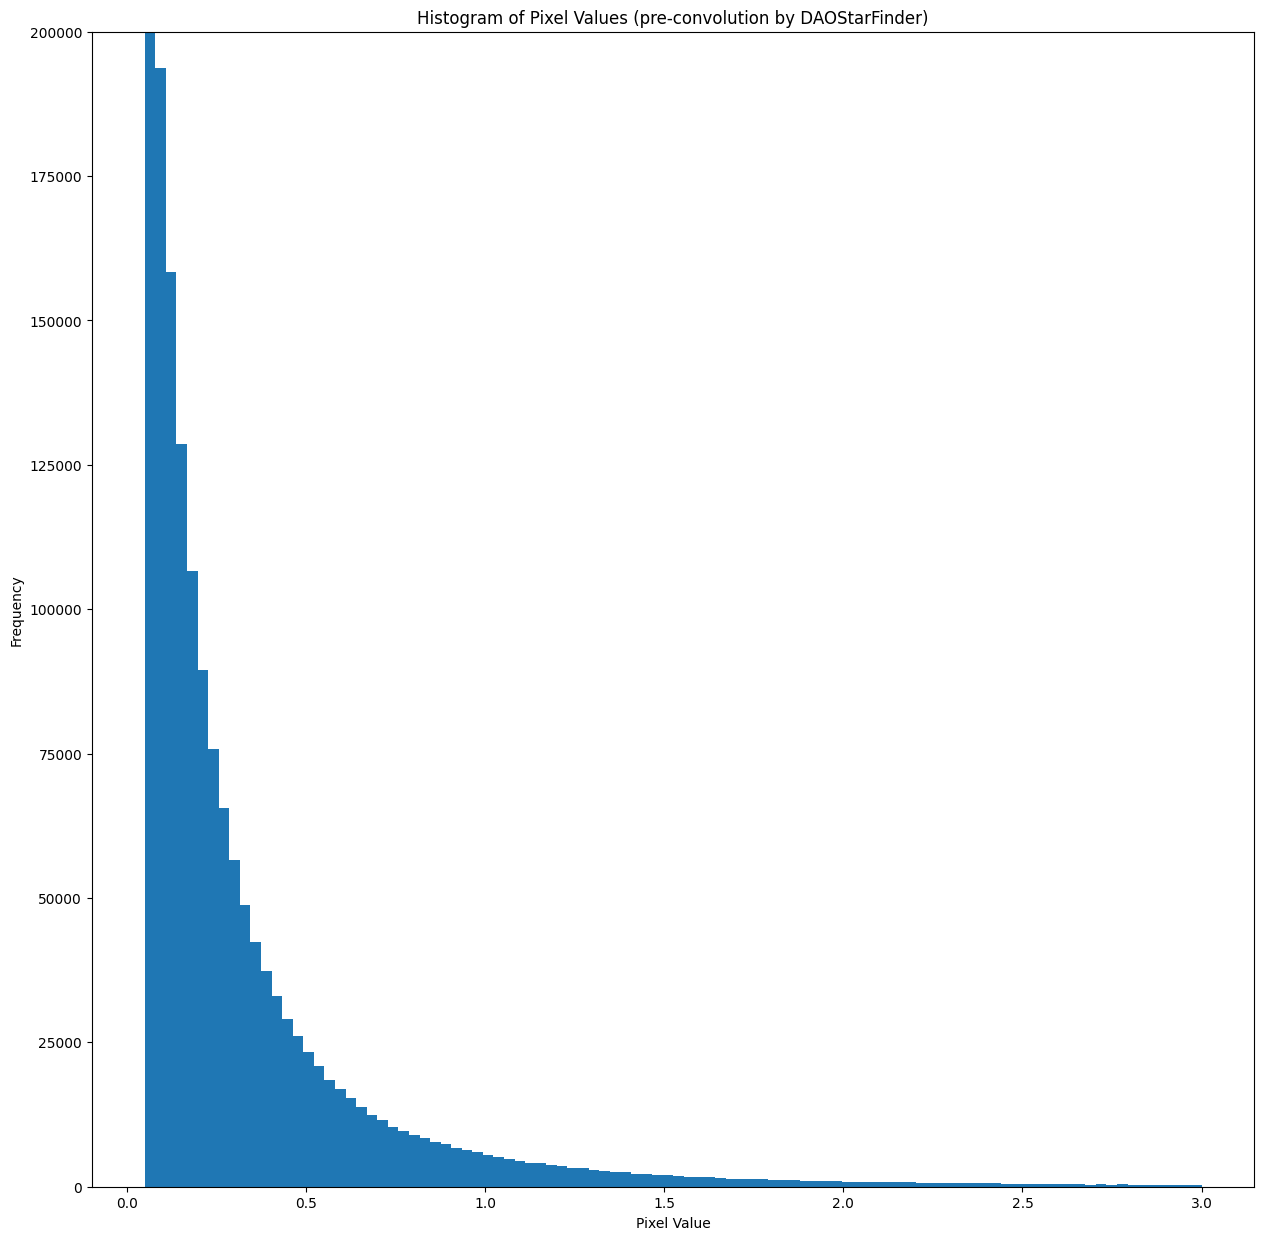

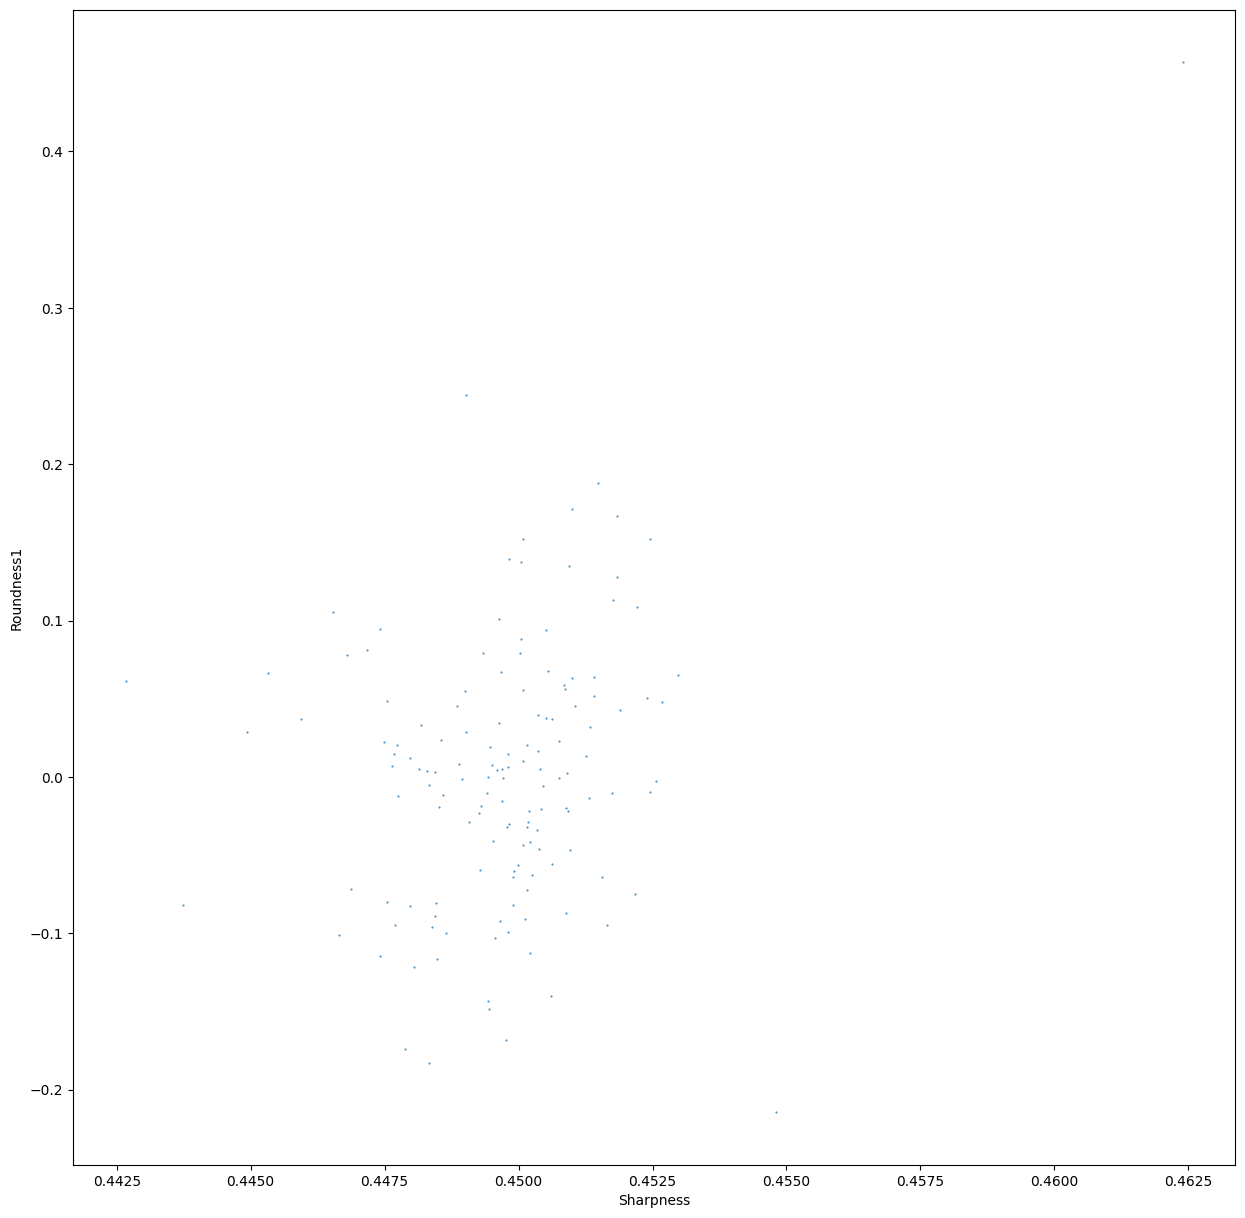

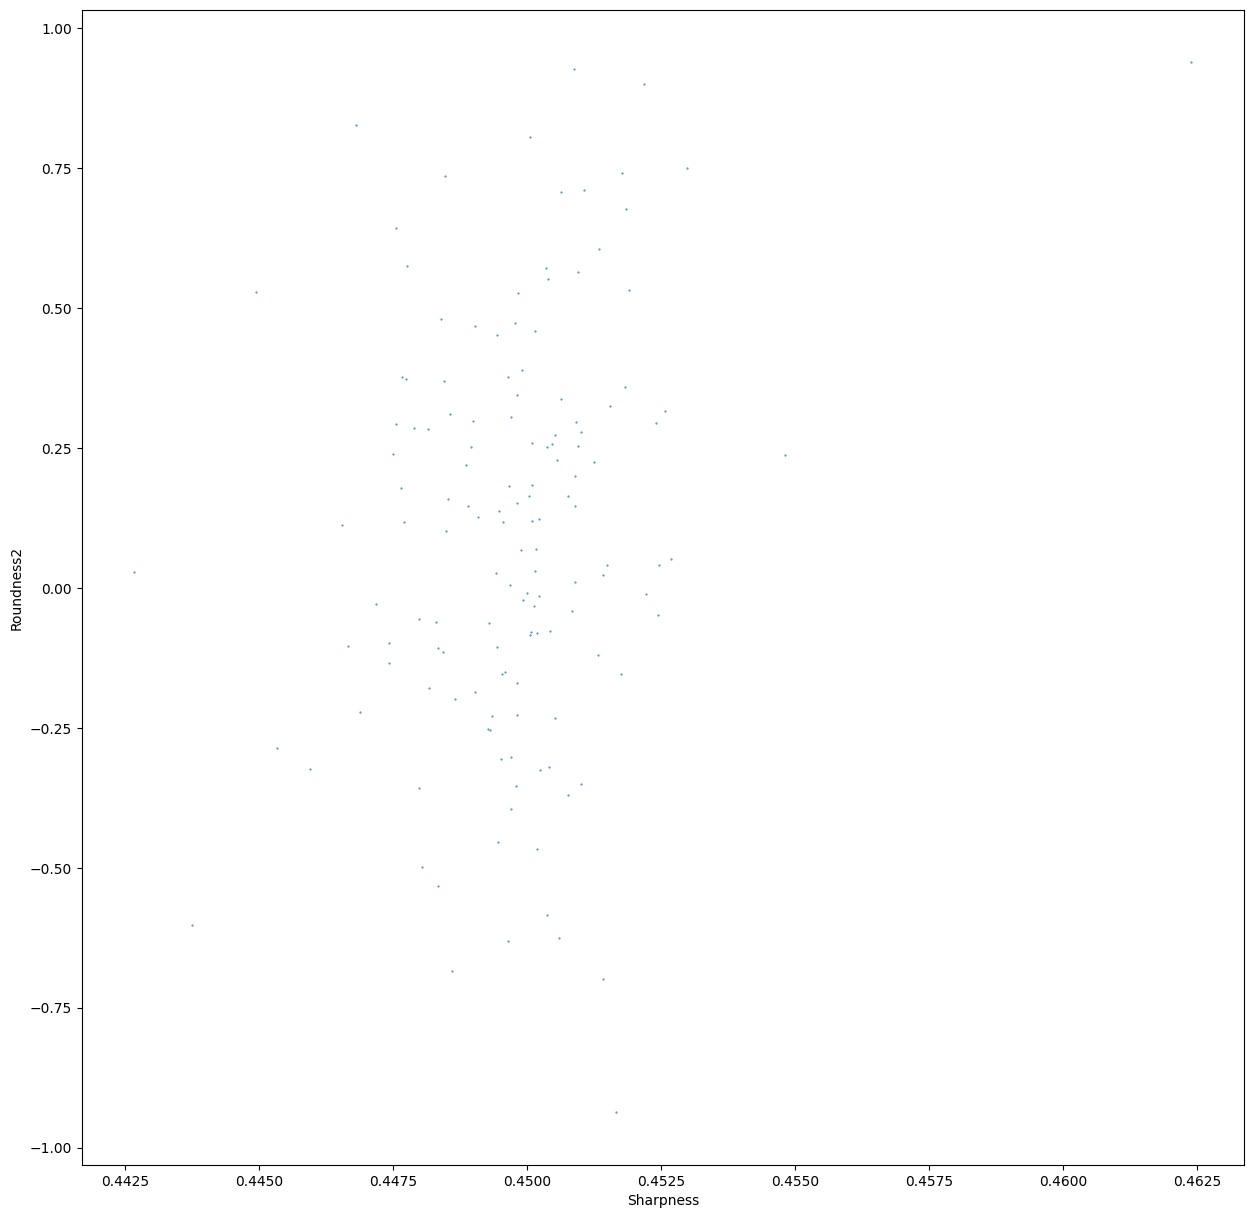

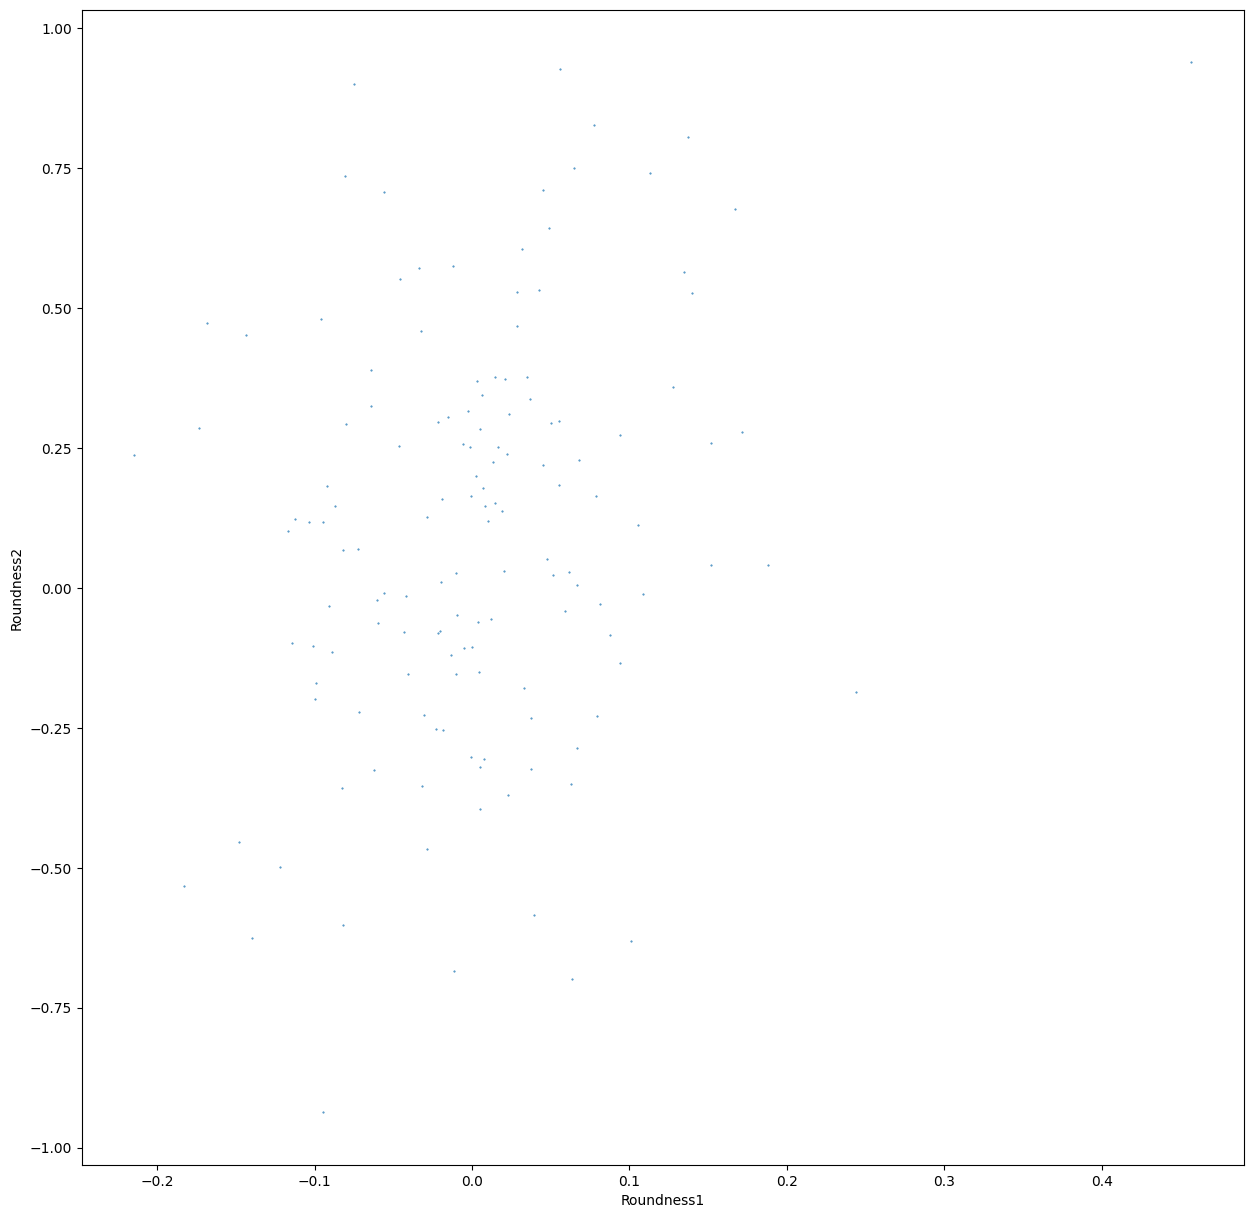

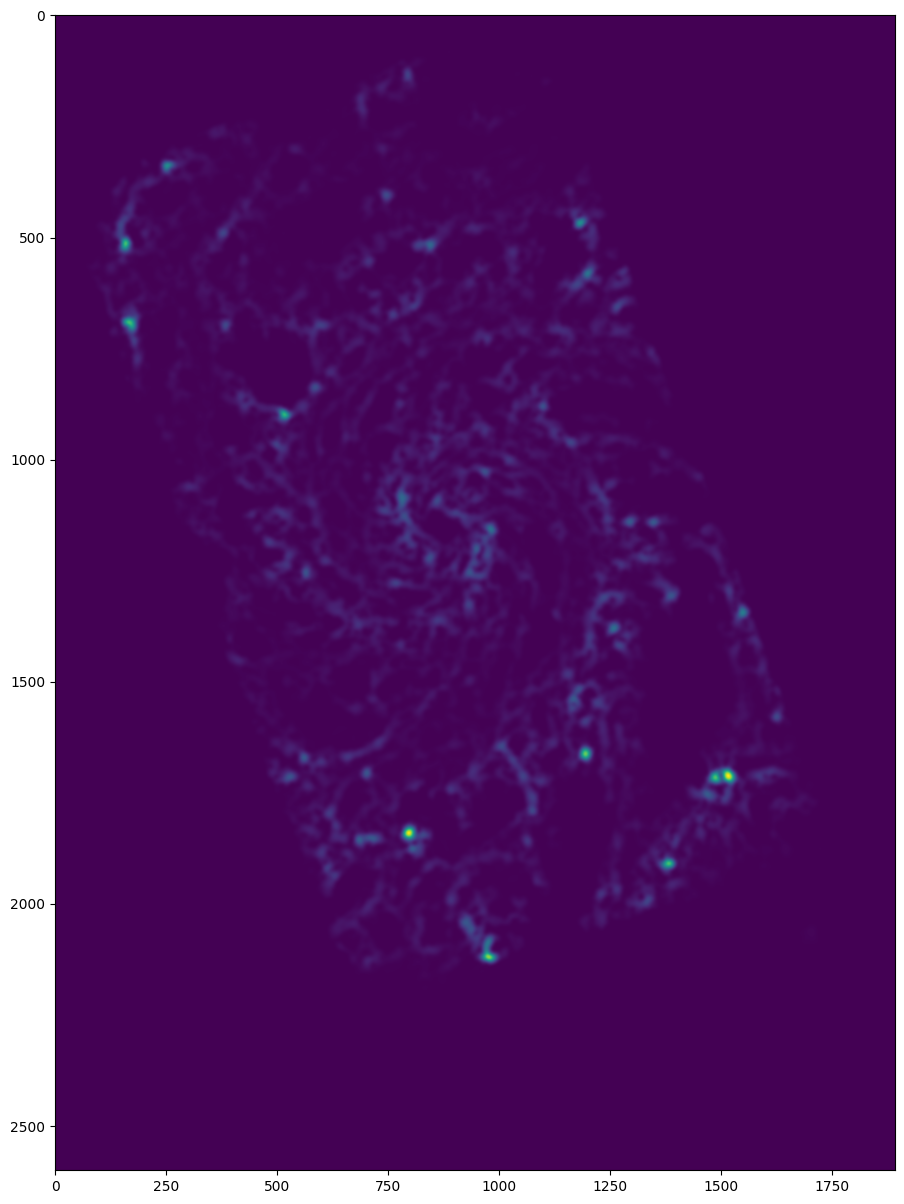

11


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


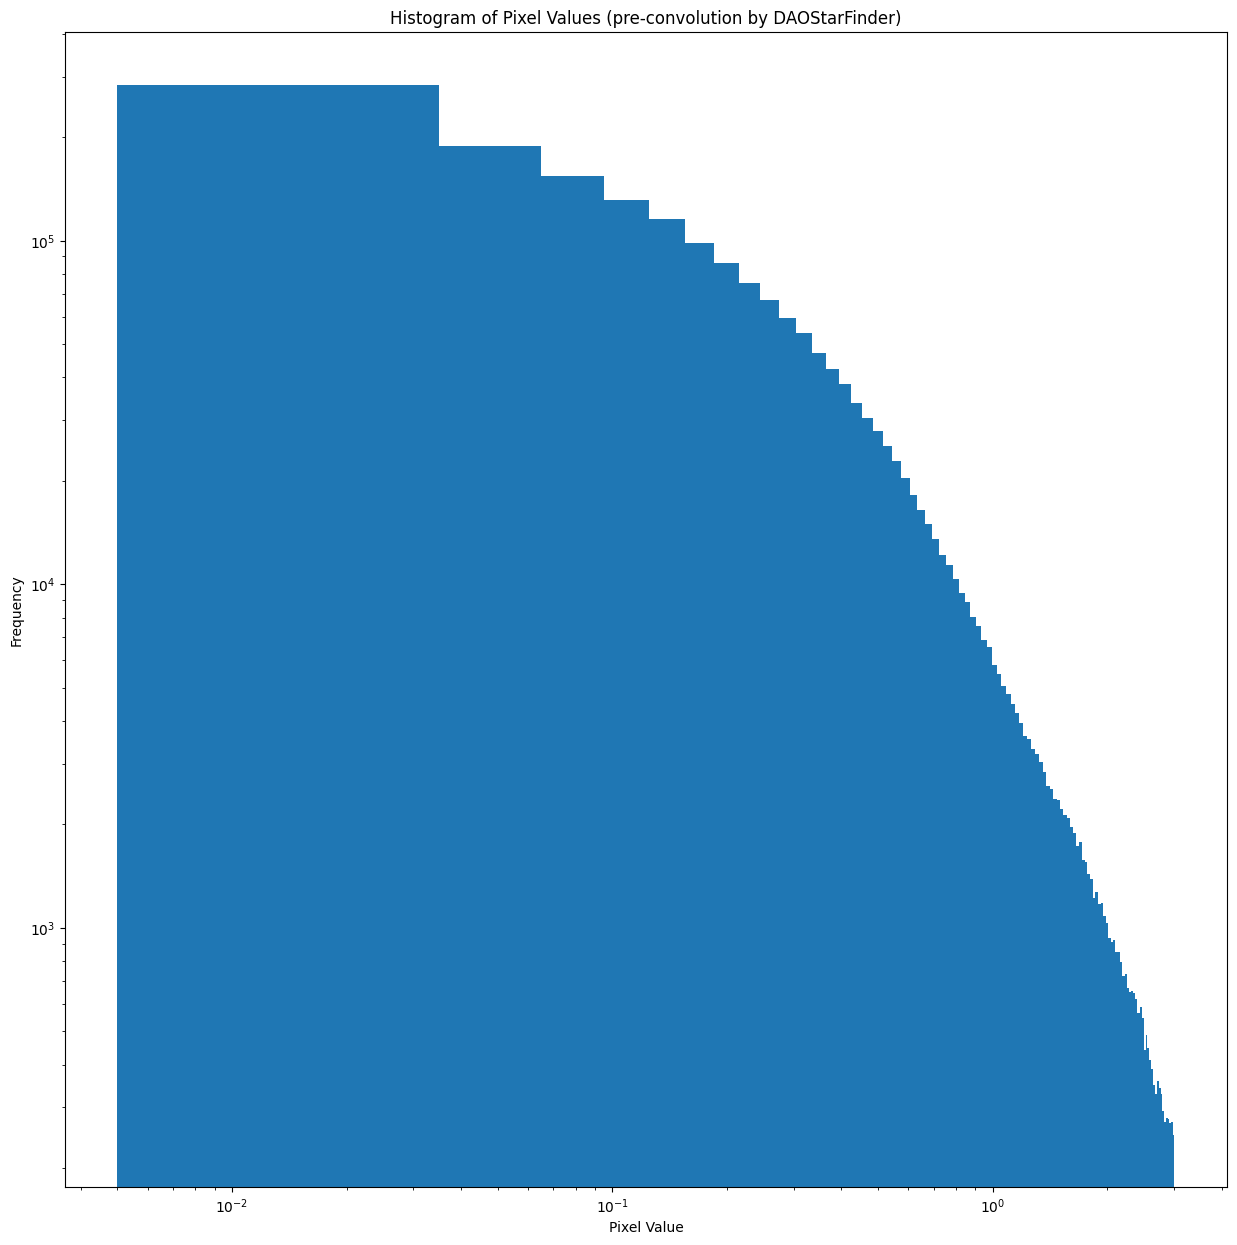

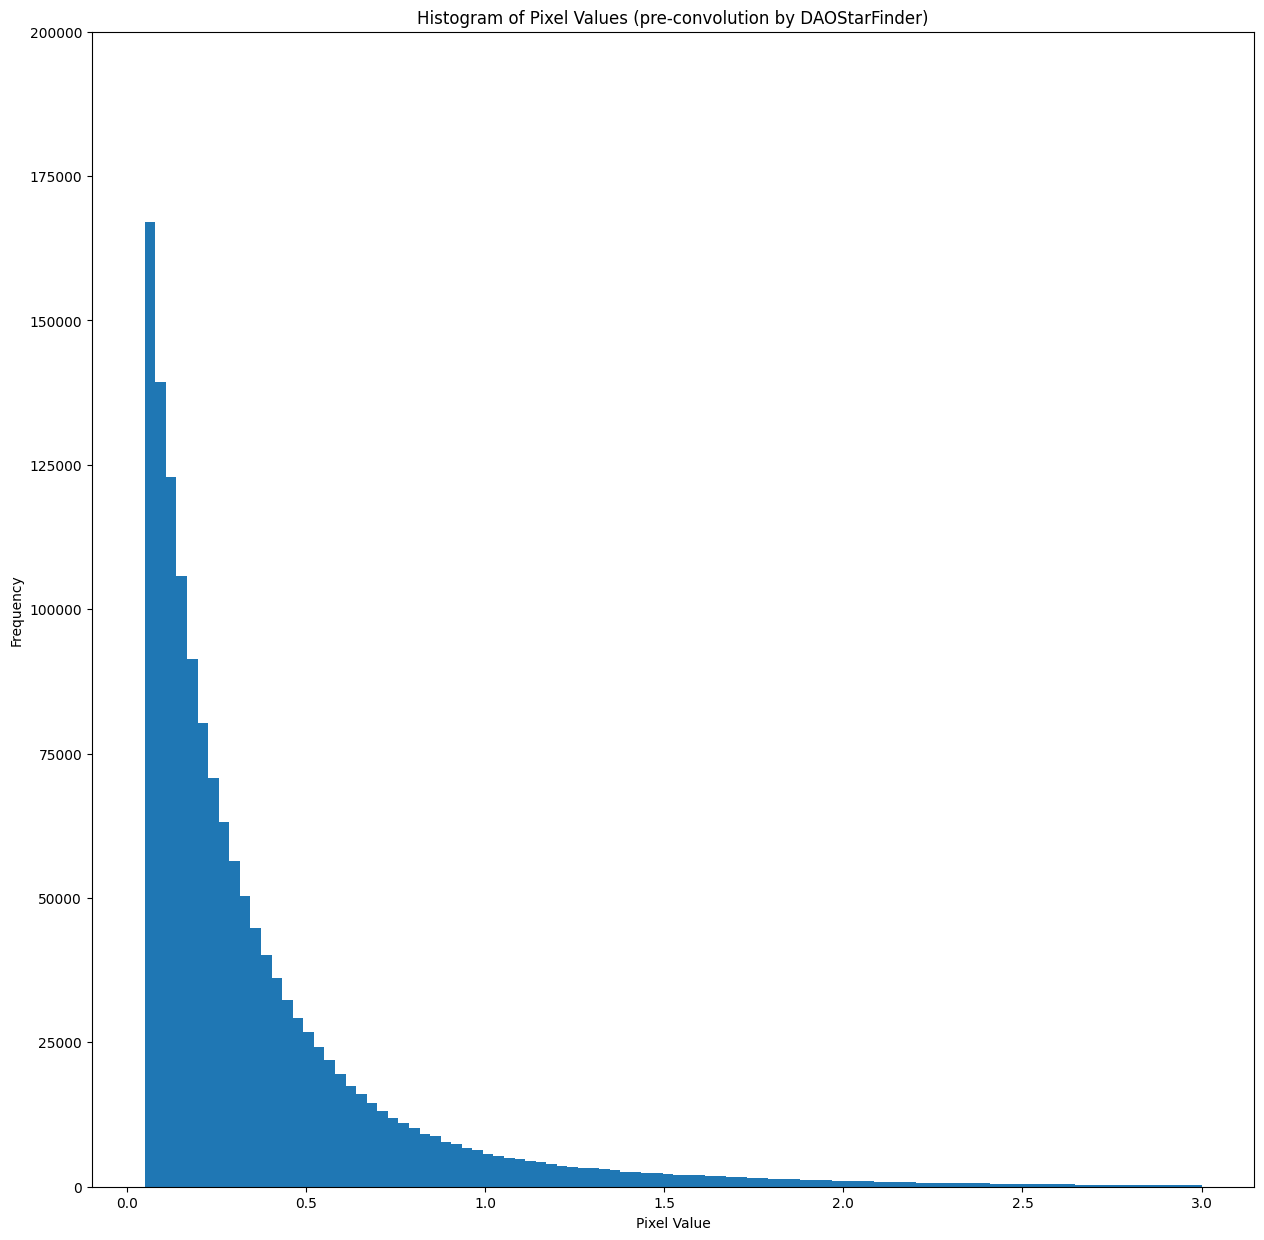

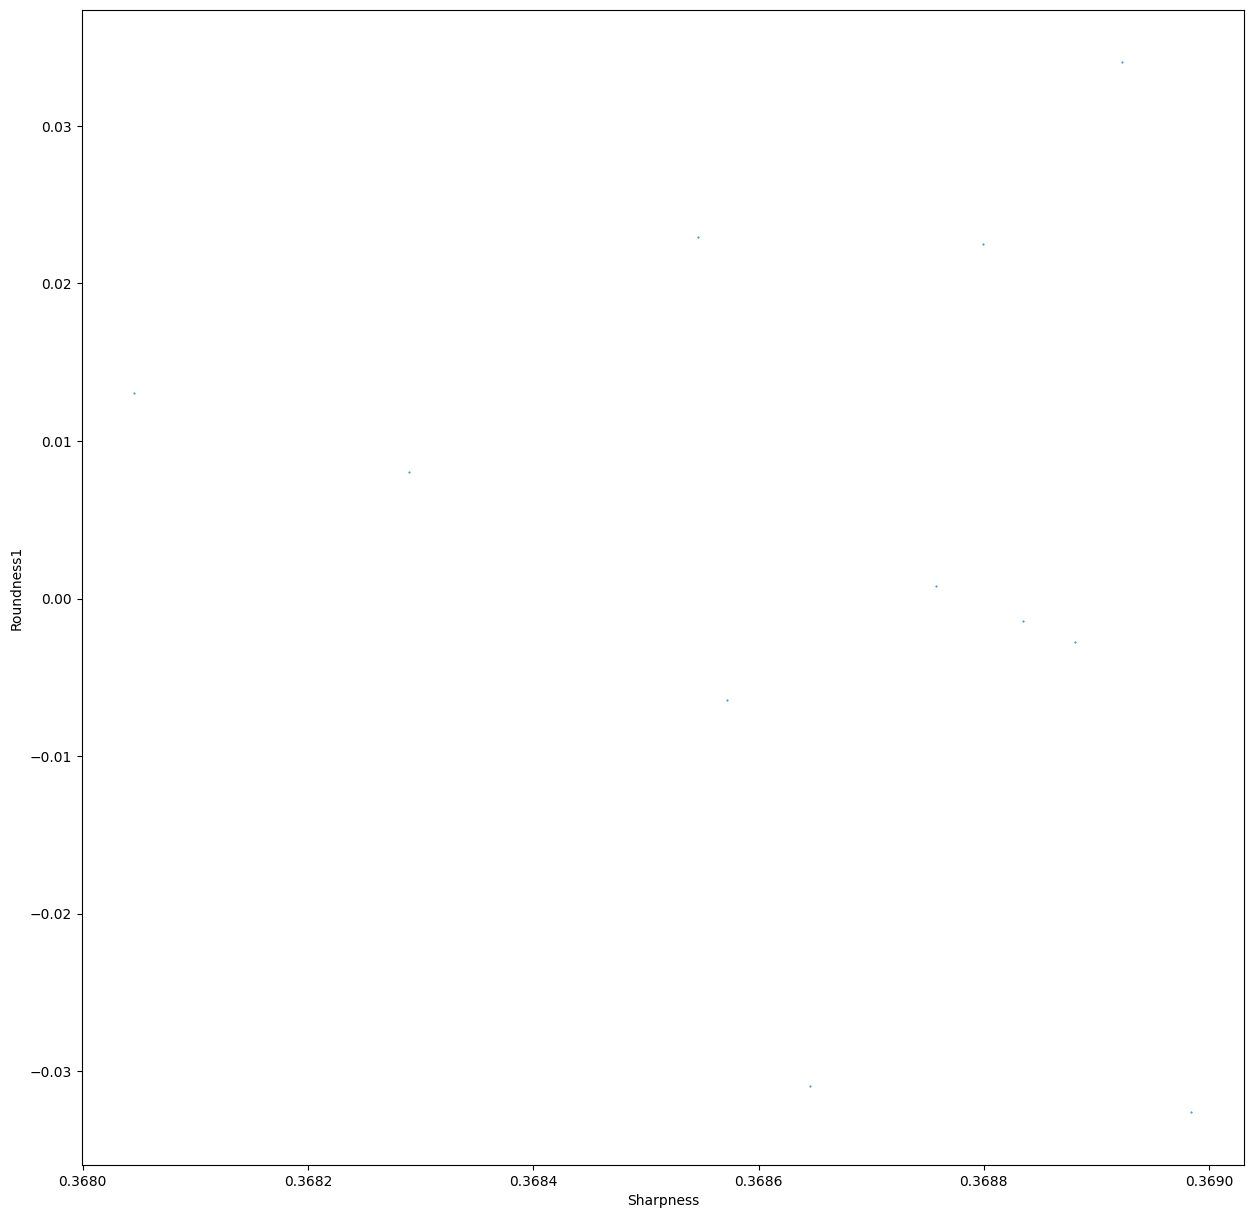

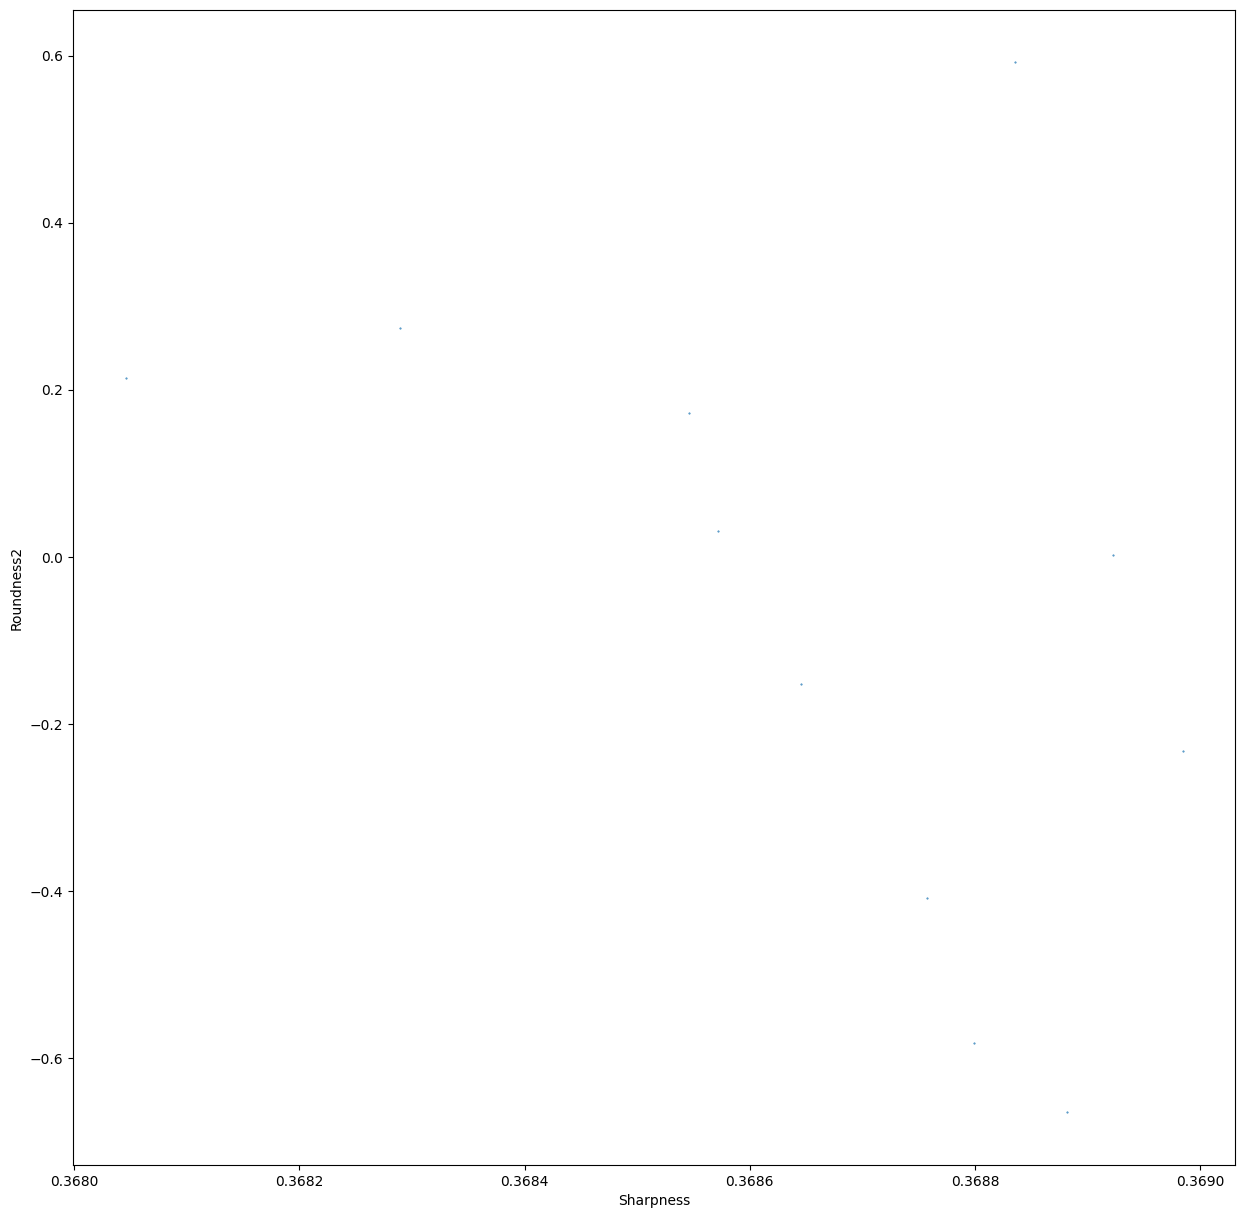

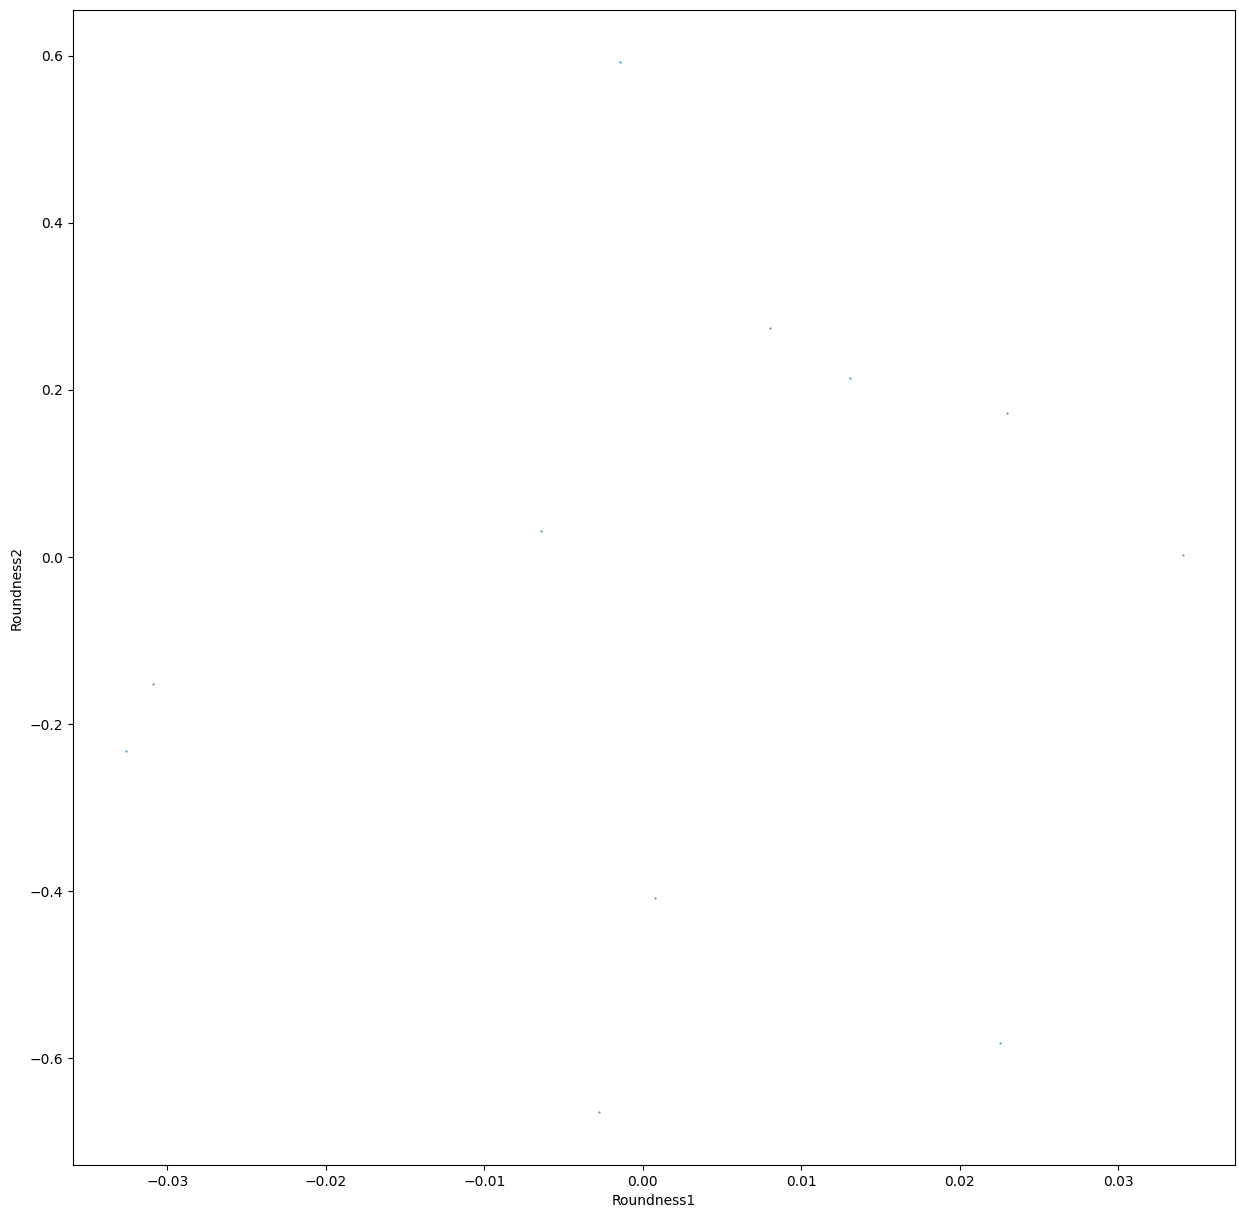

In [33]:
# DO SOURCE DETECTION ON THE SMALL SCALE CONSTRAINED DIFFUSE DECOMPOSITION IMAGE(S) GENERATED USING PIXEL SCALE LADDER, RATHER THAN SPATIAL SCALE LADDER
# ... CAN BE PRODUCED USING phangs_F770W_CDD.ipynb or equivalent

doplots=False
bandstr='F770W'
inststr='MIRI'
threshscale1=1. # this is in units of sigma but will be multiplied by sigma_MJysr below to get into units of our JWST data [MJy/sr],
                # the peak value is evaluated _after_ DAOstarfinder's convolution with the detection kernel (a lowered Gaussian)
                # so the appropriate threshold depends on kernel profile/FWHM and will be modified below using threshfact
#scalenum=3      # 1, 2, 3 are most relevant for point, nearly-point sources


cdd_dir = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource"


res_as = .269
pix_as = .11
rmaskpix = res_as/pix_as*2
threshfact=[1.0,0.34,0.38]
sigma_MJysr=0.11



scalenum = 1


for galaxy in os.listdir(cdd_dir):
    image_path = os.path.join(cdd_dir, galaxy)
    with fits.open(image_path) as hdul:
        data = hdul['SCI'].data
        header = hdul['SCI'].header



    galaxy, extension = os.path.splitext(galaxy)

    findfwhmpix=np.max([2**(scalenum-1),res_as/pix_as])
    findthreshval=(threshscale1*sigma_MJysr)/threshfact[scalenum-1]

    data = np.nan_to_num(data, nan=0.0)  # Replace NaNs with 0


    plt.imshow(data)
    plt.show()

    #SHOULD TRY MAKING MASKS WITH A FEW CHOICES OF THRESHOLD, THEN RUN THROUGH CLOUD CLEAN TO EVALUATE APPEARANCE
    #NOTE THAT THRESHOLD REFERS TO THE VALUES ON THE INPUT IMAGE _AFTER__ CONVOLUTION WITH THE LOWERED GAUSSIAN KERNEL OF DAOSTARFINDER
    daofind = DAOStarFinder(fwhm=findfwhmpix, threshold=findthreshval, roundhi=1, roundlo=-1, sharphi=1.0, sharplo=0.2, min_separation=findfwhmpix)
    sources = daofind(data - 0.) # bkgd already subtracted when using constrained diffusion decomp input
    print(len(sources))
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=res_as/pix_as)

    # Sort the sources table by flux in descending order
    sources = sources[np.argsort(sources['flux'] )[::-1]]

    # Add RA and Dec columns to the sources table using the WCS
    wcs = WCS(header)
    #SkyPos = wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])
    SkyPos = astropy.wcs.utils.pixel_to_skycoord(sources['xcentroid'], sources['ycentroid'],wcs=wcs,origin=0)
    sources['ra'] = SkyPos.ra.degree
    sources['dec'] = SkyPos.dec.degree

    # Convert the sources array to an astropy table
    sources_table = Table(sources)

    # Write the table to a FITS file
    sources_table.write(galaxy +'pix_sources_table.fits', overwrite=True)
    scalenum+=1

    plt.hist(data.flatten(), bins=100, range=[0.005, 3], log=True)
    plt.xscale('log')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values (pre-convolution by DAOStarFinder)')
    plt.show()

    plt.hist(data.flatten(), bins=100, range=[0.05, 3], log=False)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values (pre-convolution by DAOStarFinder)')
    plt.ylim(0,2e5)
    plt.show()

    # uncomment to plot image with sources marked
    #plt.figure(figsize=(150, 150))
    #plt.imshow(data, cmap='Greys', origin='lower', norm=ImageNormalize(stretch=SqrtStretch(),vmin=0,vmax=3.), interpolation='nearest')
    #apertures.plot(color='red', lw=0.5, alpha=0.99)
    #plt.show()

    plt.scatter(sources['sharpness'], sources['roundness1'], s=0.2)
    plt.xlabel('Sharpness')
    plt.ylabel('Roundness1')
    plt.show()

    plt.scatter(sources['sharpness'], sources['roundness2'], s=0.2)
    plt.xlabel('Sharpness')
    plt.ylabel('Roundness2')
    plt.show()

    plt.scatter(sources['roundness1'], sources['roundness2'], s=0.2)
    plt.xlabel('Roundness1')
    plt.ylabel('Roundness2')
    plt.show()

    # Create a mask containing all sources

    mask = np.zeros_like(data, dtype=int)
    for pos in positions:
        aperture = CircularAperture(pos, r=rmaskpix)  # Create aperture for each position, !!! possibly have radius scale with intensity, larger for bright sources
        aperture_mask = aperture.to_mask(method='center')  # Create a mask for each aperture

        aperture_shape = aperture_mask.data.shape

        y_center, x_center = int(pos[1]), int(pos[0])

        # Ensure that the indices are within the bounds of the image
        y_min = max(0, y_center - aperture_shape[0] // 2)
        y_max = min(mask.shape[0], y_center + aperture_shape[0] // 2)
        x_min = max(0, x_center - aperture_shape[1] // 2)
        x_max = min(mask.shape[1], x_center + aperture_shape[1] // 2)

        # Place the aperture mask on the correct part of the full mask
        mask[y_min:y_max, x_min:x_max] = np.maximum(
            mask[y_min:y_max, x_min:x_max],
            aperture_mask.data[
                aperture_shape[0] // 2 - (y_center - y_min):aperture_shape[0] // 2 + (y_max - y_center),
                aperture_shape[1] // 2 - (x_center - x_min):aperture_shape[1] // 2 + (x_max - x_center)
            ].astype(int)
        )

    # Save the mask as a FITS file
    save_path = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCdd.fits"
    hdu = fits.PrimaryHDU(mask, header=header)
    hdu.writeto(save_path, overwrite=True)


In [34]:
#version with representative ra,dec

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, vstack
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def crossmatch_fits_tables(table1_path, table2_path, table3_path, sep_arcsec=0.22):
    """
    Cross-matches three FITS tables based on sky position, categorizing matches
    as triple, double, or single, and retaining all sources.
    Includes angular separations between matched components and average sky positions
    in the output.

    Args:
        table1_path (str): Path to the first FITS table.
        table2_path (str): Path to the second FITS table.
        table3_path (str): Path to the third FITS table.
        sep_arcsec (float): Maximum separation in arcseconds for a match.

    Returns:
        astropy.table.Table: A table containing all sources, with columns indicating
                             their match type, properties from the matched tables,
                             angular separations where applicable, and average RA/Dec.
    """
    # Define common column names that are expected in your FITS tables.
    # These columns will be extracted and prefixed (e.g., 't1_ra', 't2_flux')
    # in the final output table. Add or remove columns as per your FITS file schema.
    common_source_cols = [
        'ra', 'dec', 'flux', 'peak', 'xcentroid', 'ycentroid',
        'sharpness', 'roundness1', 'roundness2',
        # Add any other relevant columns like 'mag', 'err', etc.
    ]

    # --- 1. Read Tables and Prepare for Analysis ---
    try:
        table1 = Table.read(table1_path)
        table2 = Table.read(table2_path)
        table3 = Table.read(table3_path)
    except FileNotFoundError as e:
        print(f"Error: One or more FITS files not found: {e}")
        return Table() # Return an empty table on file error
    except Exception as e:
        print(f"An unexpected error occurred while reading FITS files: {e}")
        return Table()

    # Prepare tables for vstacking: add 'origin', 'original_id', and ensure common columns
    tables_to_stack = []
    for i, table in enumerate([table1, table2, table3]):
        table_name = f'table{i+1}'
        table['origin'] = table_name  # Mark the original table for each source
        table['original_id'] = np.arange(len(table)) # Unique ID within its original table

        # Ensure all columns defined in `common_source_cols` exist in the table.
        # If a column is missing, add it with NaN values to maintain consistent structure.
        for col_name in common_source_cols:
            if col_name not in table.colnames:
                # Use np.full to create an array of NaNs matching table length
                table[col_name] = np.full(len(table), np.nan)
        tables_to_stack.append(table)

    # Concatenate all pre-processed tables into a single table.
    # 'exact' join_type ensures that all tables have the same column set (which we enforced).
    all_sources = vstack(tables_to_stack, join_type='exact')

    # Create SkyCoord objects for all sources for spatial matching
    all_coords = SkyCoord(ra=all_sources['ra'] * u.deg, dec=all_sources['dec'] * u.deg)

    # --- 2. Find Spatially Connected Components ---
    # Use search_around_sky to find all pairs of sources within the specified separation.
    # We search the combined catalog against itself to identify all potential matches.
    idx_all1, idx_all2, d2d_all, _ = all_coords.search_around_sky(all_coords, seplimit=sep_arcsec * u.arcsec)

    # Filter out self-matches (a source matching itself) to build a proper adjacency matrix.
    valid_indices_mask = idx_all1 != idx_all2
    row_indices = idx_all1[valid_indices_mask]
    col_indices = idx_all2[valid_indices_mask]

    # Create an adjacency matrix where an edge exists if two sources are within sep_arcsec.
    # This matrix will be used to find connected components (groups of matched sources).
    n_sources = len(all_sources)
    data = np.ones(len(row_indices), dtype=int) # Data for the sparse matrix (just indicating presence of a connection)
    adj_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(n_sources, n_sources))

    # Use scipy's connected_components to find groups of sources that are interconnected.
    # Each unique 'label' corresponds to a distinct group of matched sources.
    n_components, labels = connected_components(adj_matrix, directed=False)
    all_sources['component_id'] = labels # Assign the component ID to each source

    # --- 3. Categorize Components into Match Types ---
    # Initialize lists to store components based on their match type
    triple_components = []
    double_12_components = [] # Sources from table1 and table2
    double_13_components = [] # Sources from table1 and table3
    double_23_components = [] # Sources from table2 and table3
    single_components = []    # Unmatched sources (only from one table in a component)

    # Iterate through each unique component found and categorize it
    for i in range(n_components):
        component_sources = all_sources[all_sources['component_id'] == i]
        # Determine which original tables are represented in this component
        origins_in_component = set(component_sources['origin'])

        if len(origins_in_component) == 3:
            # Component contains sources from all three tables
            triple_components.append(component_sources)
        elif len(origins_in_component) == 2:
            # Component contains sources from exactly two tables (double match)
            if 'table1' in origins_in_component and 'table2' in origins_in_component:
                double_12_components.append(component_sources)
            elif 'table1' in origins_in_component and 'table3' in origins_in_component:
                double_13_components.append(component_sources)
            elif 'table2' in origins_in_component and 'table3' in origins_in_component:
                double_23_components.append(component_sources)
        elif len(origins_in_component) == 1:
            # Component contains sources from only one table (single/unmatched)
            single_components.append(component_sources)
        # Components with more complex structures (e.g., multiple sources from the same
        # table forming a single component, or a component with 4+ sources but still
        # only 3 distinct origins) are handled by the `get_props_from_source`
        # function below which takes the first found source as a representative.

    # --- 4. Consolidate Results into a Single Output Table ---
    final_rows = []

    # Helper function to extract properties from a source or fill with NaN
    def get_props_from_source(source_table_slice, prefix):
        """
        Extracts properties from the first source in a slice of an Astropy Table
        and prefixes column names, or fills with NaN if the slice is empty.
        Handles units by extracting the `.value`.
        """
        props = {}
        if len(source_table_slice) > 0:
            # Take the first source in the slice as the representative.
            # You might extend this logic to select the brightest, or closest to centroid, etc.
            source = source_table_slice[0]
            for col_name in common_source_cols:
                # If the column has a unit, extract its numerical value.
                props[f'{prefix}_{col_name}'] = source[col_name].value if hasattr(source[col_name], 'value') else source[col_name]
        else:
            # If no sources from this table are present in the component, fill with NaN
            for col_name in common_source_cols:
                props[f'{prefix}_{col_name}'] = np.nan
        return props

    # Define all possible output column names for the final table.
    # This ensures consistency even if certain match types don't populate all columns.
    output_colnames = ['match_type', 'component_id']
    for prefix in ['t1', 't2', 't3']: # For tables 1, 2, and 3
        for col_name in common_source_cols:
            output_colnames.append(f'{prefix}_{col_name}')
    # Add columns for angular separations
    output_colnames.extend(['sep_t1_t2', 'sep_t1_t3', 'sep_t2_t3'])
    # Add columns for average RA and Dec
    output_colnames.extend(['ra', 'dec'])

    # Process Triple Matches
    for component_sources in triple_components:
        component_id_val = component_sources['component_id'][0] # All sources in component share ID
        row_data = {'match_type': 'triple_match', 'component_id': component_id_val}

        # Get sources belonging to each table within this component
        t1_sources = component_sources[component_sources['origin'] == 'table1']
        t2_sources = component_sources[component_sources['origin'] == 'table2']
        t3_sources = component_sources[component_sources['origin'] == 'table3']

        # Add properties, prefixed by 't1_', 't2_', 't3_'
        row_data.update(get_props_from_source(t1_sources, 't1'))
        row_data.update(get_props_from_source(t2_sources, 't2'))
        row_data.update(get_props_from_source(t3_sources, 't3'))

        # Calculate angular separations for triple matches
        coord1 = SkyCoord(ra=t1_sources[0]['ra'] * u.deg, dec=t1_sources[0]['dec'] * u.deg)
        coord2 = SkyCoord(ra=t2_sources[0]['ra'] * u.deg, dec=t2_sources[0]['dec'] * u.deg)
        coord3 = SkyCoord(ra=t3_sources[0]['ra'] * u.deg, dec=t3_sources[0]['dec'] * u.deg)

        row_data['sep_t1_t2'] = coord1.separation(coord2).to(u.arcsec).value
        row_data['sep_t1_t3'] = coord1.separation(coord3).to(u.arcsec).value
        row_data['sep_t2_t3'] = coord2.separation(coord3).to(u.arcsec).value

        # Calculate average RA and Dec for triple matches
        avg_ra_coords = [coord1.ra.value, coord2.ra.value, coord3.ra.value]
        avg_dec_coords = [coord1.dec.value, coord2.dec.value, coord3.dec.value]

        row_data['ra'] = np.mean(avg_ra_coords)
        row_data['dec'] = np.mean(avg_dec_coords)

        final_rows.append(row_data)

    # Process Double Matches (Table 1 and Table 2)
    for component_sources in double_12_components:
        component_id_val = component_sources['component_id'][0]
        row_data = {'match_type': 'double_12_match', 'component_id': component_id_val}

        t1_sources = component_sources[component_sources['origin'] == 'table1']
        t2_sources = component_sources[component_sources['origin'] == 'table2']
        t3_sources = Table() # An empty table slice to ensure t3_ properties are filled with NaN

        row_data.update(get_props_from_source(t1_sources, 't1'))
        row_data.update(get_props_from_source(t2_sources, 't2'))
        row_data.update(get_props_from_source(t3_sources, 't3')) # This will add t3_... columns with NaNs

        # Calculate angular separations for double 1-2 matches
        coord1 = SkyCoord(ra=t1_sources[0]['ra'] * u.deg, dec=t1_sources[0]['dec'] * u.deg)
        coord2 = SkyCoord(ra=t2_sources[0]['ra'] * u.deg, dec=t2_sources[0]['dec'] * u.deg)

        row_data['sep_t1_t2'] = coord1.separation(coord2).to(u.arcsec).value
        row_data['sep_t1_t3'] = np.nan # No match to table3
        row_data['sep_t2_t3'] = np.nan # No match to table3

        # Calculate average RA and Dec for double 1-2 matches
        avg_ra_coords = [coord1.ra.value, coord2.ra.value]
        avg_dec_coords = [coord1.dec.value, coord2.dec.value]

        row_data['ra'] = np.mean(avg_ra_coords)
        row_data['dec'] = np.mean(avg_dec_coords)

        final_rows.append(row_data)

    # Process Double Matches (Table 1 and Table 3)
    for component_sources in double_13_components:
        component_id_val = component_sources['component_id'][0]
        row_data = {'match_type': 'double_13_match', 'component_id': component_id_val}

        t1_sources = component_sources[component_sources['origin'] == 'table1']
        t2_sources = Table() # Empty table slice for t2_ NaNs
        t3_sources = component_sources[component_sources['origin'] == 'table3']

        row_data.update(get_props_from_source(t1_sources, 't1'))
        row_data.update(get_props_from_source(t2_sources, 't2')) # This will add t2_... columns with NaNs
        row_data.update(get_props_from_source(t3_sources, 't3'))

        # Calculate angular separations for double 1-3 matches
        coord1 = SkyCoord(ra=t1_sources[0]['ra'] * u.deg, dec=t1_sources[0]['dec'] * u.deg)
        coord3 = SkyCoord(ra=t3_sources[0]['ra'] * u.deg, dec=t3_sources[0]['dec'] * u.deg)

        row_data['sep_t1_t2'] = np.nan # No match to table2
        row_data['sep_t1_t3'] = coord1.separation(coord3).to(u.arcsec).value
        row_data['sep_t2_t3'] = np.nan # No match to table2

        # Calculate average RA and Dec for double 1-3 matches
        avg_ra_coords = [coord1.ra.value, coord3.ra.value]
        avg_dec_coords = [coord1.dec.value, coord3.dec.value]

        row_data['ra'] = np.mean(avg_ra_coords)
        row_data['dec'] = np.mean(avg_dec_coords)

        final_rows.append(row_data)

    # Process Double Matches (Table 2 and Table 3)
    for component_sources in double_23_components:
        component_id_val = component_sources['component_id'][0]
        row_data = {'match_type': 'double_23_match', 'component_id': component_id_val}

        t1_sources = Table() # Empty table slice for t1_ NaNs
        t2_sources = component_sources[component_sources['origin'] == 'table2']
        t3_sources = component_sources[component_sources['origin'] == 'table3']

        row_data.update(get_props_from_source(t1_sources, 't1')) # This will add t1_... columns with NaNs
        row_data.update(get_props_from_source(t2_sources, 't2'))
        row_data.update(get_props_from_source(t3_sources, 't3'))

        # Calculate angular separations for double 2-3 matches
        coord2 = SkyCoord(ra=t2_sources[0]['ra'] * u.deg, dec=t2_sources[0]['dec'] * u.deg)
        coord3 = SkyCoord(ra=t3_sources[0]['ra'] * u.deg, dec=t3_sources[0]['dec'] * u.deg)

        row_data['sep_t1_t2'] = np.nan # No match to table1
        row_data['sep_t1_t3'] = np.nan # No match to table1
        row_data['sep_t2_t3'] = coord2.separation(coord3).to(u.arcsec).value

        # Calculate average RA and Dec for double 2-3 matches
        avg_ra_coords = [coord2.ra.value, coord3.ra.value]
        avg_dec_coords = [coord2.dec.value, coord3.dec.value]

        row_data['ra'] = np.mean(avg_ra_coords)
        row_data['dec'] = np.mean(avg_dec_coords)

        final_rows.append(row_data)

    # Process Single Matches (unmatched sources)
    for component_sources in single_components:
        component_id_val = component_sources['component_id'][0]
        row_data = {'match_type': 'single_unmatched', 'component_id': component_id_val}

        # Determine which original table this single source came from
        origin_table = component_sources['origin'][0]

        # Populate the correct prefixed columns based on the source's origin
        t1_sources = component_sources if origin_table == 'table1' else Table()
        t2_sources = component_sources if origin_table == 'table2' else Table()
        t3_sources = component_sources if origin_table == 'table3' else Table()

        row_data.update(get_props_from_source(t1_sources, 't1'))
        row_data.update(get_props_from_source(t2_sources, 't2'))
        row_data.update(get_props_from_source(t3_sources, 't3'))

        # For single matches, all separations are NaN
        row_data['sep_t1_t2'] = np.nan
        row_data['sep_t1_t3'] = np.nan
        row_data['sep_t2_t3'] = np.nan

        # For single matches, average RA/Dec is simply its own RA/Dec
        if len(component_sources) > 0:
            row_data['ra'] = component_sources[0]['ra']
            row_data['dec'] = component_sources[0]['dec']
        else:
            row_data['ra'] = np.nan
            row_data['dec'] = np.nan

        final_rows.append(row_data)

    # Create the final Astropy Table from the collected rows.
    if final_rows:
        # Create the table from the list of dictionaries
        final_result = Table(rows=final_rows)
        # Ensure 'match_type' and 'component_id' are at the beginning for clarity
        final_result = final_result[output_colnames]
    else:
        # If no sources were found or matched, return an empty table with the defined columns
        final_result = Table(names=output_colnames)

    return final_result

In [35]:
table1_path= r"ngc0628_F770W_JWST_Emission_starsub_CDDss0032pcpix_sources_table.fits"
table2_path= r"ngc0628_F770W_JWST_Emission_starsub_CDDss0016pcpix_sources_table.fits"
table3_path= r"ngc0628_F770W_JWST_Emission_starsub_CDDss0064pcpix_sources_table.fits"

combined_catalog = crossmatch_fits_tables(table1_path, table2_path, table3_path, sep_arcsec=0.22)

In [36]:
print(combined_catalog)
print(combined_catalog.colnames)
combined_catalog.write('CDDfs_sources_table.fits', overwrite=True)

   match_type    component_id ...         ra                dec        
---------------- ------------ ... ------------------ ------------------
    triple_match            1 ... 24.176370339255755 15.804717539253907
    triple_match            2 ...  24.17059937583181 15.813314678752016
    triple_match            4 ...  24.18530581197096 15.775705297262329
    triple_match            5 ... 24.193727891689292 15.758450556900891
    triple_match            6 ... 24.196607031148037 15.769273788075251
 double_12_match            0 ... 24.157570559153143 15.806798883062843
 double_12_match            3 ... 24.196640576948077 15.763824147602381
 double_12_match            8 ... 24.163682963985373 15.799199397720646
 double_12_match            9 ... 24.163465594682698 15.765895315980565
 double_12_match           11 ... 24.196189664779986 15.769659421812271
             ...          ... ...                ...                ...
single_unmatched        16296 ... 24.144876834760368  15.8132361

In [37]:
def write_ds9_region_file(table, filename, radius_arcsec=1.0):
    """
    Writes a DS9 region file from an Astropy table containing RA and Dec columns.

    Args:
        table (astropy.table.Table): An Astropy table with 'ra' and 'dec' columns
                                     (in degrees) and optionally a 'match_type' column.
        filename (str): The name of the output DS9 region file (e.g., 'regions.reg').
        radius_arcsec (float): The radius of the circle region in arcseconds.
                                Defaults to 1.0 arcsec.
    """
    with open(filename, 'w') as f:
        # Write the DS9 region file header
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('icrs\n')  # Use ICRS coordinate system

        # Iterate through each row (source) in the table
        for row in table:
            ra = row['ra']
            dec = row['dec']
            # Optional: Customize color or text based on match_type
            color = 'green'
            label = ''
            if 'match_type' in row.colnames:
                match_type = row['match_type']
                if match_type == 'triple_match':
                    color = 'red'
                    label = 'Triple'
                elif match_type.startswith('double_'):
                    color = 'yellow'
                    label = match_type.replace('_match', '').replace('double_', '').upper()
                else: # single_unmatched
                    color = 'cyan'
                    label = 'Single'

            # Write the region entry: circle(RA, Dec, Radius) # text{Label}
            f.write(f'circle({ra},{dec},{radius_arcsec}") # color={color} text={{{label}}}\n')

# Example usage (assuming combined_catalog is the Astropy Table generated previously)
# Define the output region file name
#region_filename = CDDsourcesdir+'/'+galaxy+'_'+bandstr+'_CDDfs_sources.reg'

# Write the DS9 region file using the combined catalog
#write_ds9_region_file(combined_catalog, region_filename, radius_arcsec=0.5) # Example radius

#print(f'DS9 region file written to: {region_filename}')


In [38]:
from astropy.io import fits, ascii
from astropy import wcs
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.table import QTable
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, CircularAnnulus, CircularAperture
from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry
from photutils.utils import calc_total_error
from astropy.stats import SigmaClip
from photutils.background import SExtractorBackground, Background2D, MedianBackground

from scipy.constants import c as speed_of_light
###from acstools import acszpt
from astropy.time import Time


image_path = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource\ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"


with fits.open(image_path) as hdul:
    header = hdul['SCI'].header

print(image_path)


#for subsections that are possible using phangs_JWST_CDDfs.ipynb we need to do more special treatment when image is read below (not yet implemented)
positions_sk=SkyCoord(combined_catalog['ra'],combined_catalog['dec'],unit=u.deg,frame='icrs')

bands=['f200w','f300m','f335m','f360m','f770w','f1000w','f1130w','f2100w']
bands=[bandstr.lower()]
for band in bands:

#----------------------------------------------------
# Aperture correction for HST bands:
# according to the ReadMe file:
# https://app.box.com/s/6e3j2sx60afwshwiaijn5qrcnet6e08l
# The offsets we apply to the measured V-band aperture
#correction for NUV, U, B, and I bands are
# −0.19, −0.12, −0.03, and −0.12 mags, respectively.
# for F628n, F627n, F550m, F547m the values were
#derived using linear interpolation

#Aperture corrections for Nircam band:
#were derived by Brad Whitmore
#Mail Photometry summary 5/5/2023

# JWST Vega zero points from
# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=JWST&gname2=MIRI&asttype=

# Aperture MIRI 50% encircle energy:
# https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-performance/miri-point-spread-functions
# Latest updates: original 13 Nov 2018  ?
#----------------------------------------------------

    if band=='f200w':
        ac=-0.63
        ZP_v=759.59/1e6
    if band=='f300m':
        ac=-0.68
        ZP_v=377.25/1e6
    if band=='f335m':
        ac=-0.66
        ZP_v=305.60/1e6
    if band=='f360m':
        ac=-0.67
        ZP_v=266.13/1e6
    if band=='f770w':
        r_aper_as=0.168
        ZP_v=64.83/1e6
    if band=='f1000w':
        r_aper_as=0.209
        ZP_v=38.99/1e6
    if band=='f1130w':
        r_aper_as=0.236
        ZP_v=30.42/1e6
    if band=='f2100w':
        r_aper_as=0.420
        ZP_v=9.11/1e6

    if band=='f200w':
        pix_as=0.031
        r_aper_as=4*pix_as
        an_in=2.
        an_out=3.
        an_ape_in=an_in*r_aper_as
        an_ape_out=an_out*r_aper_as

    if band=='f300m' or band=='f335m' or band=='f360m':
        pix_as=0.063
        r_aper_as=4*0.031  #use the equivalent of 4 pixels in F200W
        an_in=2.
        an_out=3.
        an_ape_in=an_in*r_aper_as
        an_ape_out=an_out*r_aper_as


    if band=='f770w' or band=='f1000w' or band=='f1130w' or band=='f2100w':
        pix_as=0.11
        an_in=2.
        an_out=3.
        an_ape_in=an_in*r_aper_as
        an_ape_out=an_out*r_aper_as





    if band=='f200w' or band=='f300m' or band=='f335m' or band=='f360m':
        hdu = fits.open(image_path)
        data = hdu['SCI'].data
        header = hdu['SCI'].header
        datan = hdu['ERR'].data
        to_MJy = header['PIXAR_SR']
        counts=header['XPOSURE']/header['PHOTMJSR']
        fg_ext=0.
        ZP_ab=3631./1e6


    if band=='f770w' or band=='f1000w' or band=='f1130w' or band=='f2100w':
        hdu = fits.open(image_path)
        data = hdu['SCI'].data
        header = hdu['SCI'].header
        datan = np.zeros_like(data) #assume no nans
        to_MJy = header['PIXAR_SR']
        ac=0.
        fg_ext=0.
        counts=header['XPOSURE']/header['PHOTMJSR']
        ZP_ab=3631./1e6




    mask=((np.isinf(data)) | (np.isnan(data)) | (np.isinf(datan)) | (np.isnan(datan)))
    data=data*counts
    datan=datan*counts


    w = WCS(header)
    x,y=skycoord_to_pixel(positions_sk, w)  # trasform sky coordinates to x, y positions in the image
    positions_xy=np.transpose((x, y))

    apertures= SkyCircularAperture(positions_sk, r_aper_as*u.arcsec)

    annulus_aperture=SkyCircularAnnulus(positions_sk, r_in=an_ape_in*u.arcsec, r_out=an_ape_out*u.arcsec)

    annulus_aperture_xy=CircularAnnulus(positions_xy, an_ape_in/pix_as, an_ape_out/pix_as)
    annulus_masks = annulus_aperture_xy.to_mask(method='exact')
    sigclip = SigmaClip(sigma=3.0, maxiters=5)


    phot=aperture_photometry(data, apertures, wcs=w, error=datan, mask=mask)
    aper_stats = ApertureStats(data, apertures, wcs=w, error=datan, sigma_clip=None, mask=mask)
    bkg_stats = ApertureStats(data, annulus_aperture, error=datan, wcs=w, sigma_clip=sigclip, mask=mask, sum_method='exact')
    #bkg_stats_2 = ApertureStats(data, annulus_aperture, error=datan, wcs=w, sigma_clip=None, mask=mask)

    bkg_median=bkg_stats.median
    bkg_median[np.isnan(bkg_median)]=0

    bkg_10=[]
    bkg_90=[]
    bkg_10_clip=[]
    bkg_90_clip=[]
    N_pixels_annulus=[]
    N_pixel_annulus_clipped=[]



    # N_pixels_aperture=[]

    # we want the range of bg values, to estimate the range of possible background levels and the uncertainty in the background
    for mask_an in annulus_masks:
        annulus_data = mask_an.multiply(data)
        #print(annulus_data)
        #print(mask_an.data)
        if annulus_data is not None:
            annulus_data_1d = mask_an.multiply(data)[(mask_an.multiply(data)!=0) & (np.isfinite(mask_an.multiply(data))) & (~np.isnan(mask_an.multiply(data)))]
            if len(annulus_data_1d)>0:
            #annulus_data=annulus_data[~np.isnan(annulus_data) & ~np.isinf(annulus_data)]
                annulus_data_filtered=sigclip(annulus_data_1d, masked=False)
                bkg_low, bkg_hi = np.quantile(annulus_data_1d, [0.1,0.9]) # the 10% and 90% values among the bg pixel values
                bkg_low_clip, bkg_hi_clip = np.quantile(annulus_data_filtered, [0.1,0.9])
                bkg_10.append(bkg_low)
                bkg_90.append(bkg_hi)
                bkg_10_clip.append(bkg_low_clip)
                bkg_90_clip.append(bkg_hi_clip)
                #annulus_data_1d = annulus_data[mask_an.data > 0]
                N_pixels_annulus.append(len(annulus_data_1d))
                #N_pixel_annulus_clipped.append(len(annulus_data_1d)-len(annulus_data_filtered))
            else:
                bkg_low=0.
                bkg_hi =0.
                bkg_10.append(bkg_low)
                bkg_90.append(bkg_hi)
                bkg_10_clip.append(0.)
                bkg_90_clip.append(0.)
                #annulus_data_1d = annulus_data[mask_an.data > 0]
                N_pixels_annulus.append(0)
        else:
            bkg_low=0.
            bkg_hi =0.# the 10% and 90% values among the bg pixel values
                #bkg_low_clip, bkg_hi_clip = np.quantile(annulus_data_filtered, [0.1,0.9])
            bkg_10.append(bkg_low)
            bkg_90.append(bkg_hi)
            bkg_10_clip.append(0)
            bkg_90_clip.append(0)
                #annulus_data_1d = annulus_data[mask_an.data > 0]
            N_pixels_annulus.append(0)




    #bkg_10=0.1*bkg_stats_2.sum
    #bkg_90=0.9*bkg_stats_2.sum
    area_aper=aper_stats.sum_aper_area.value
    area_aper[np.isnan(area_aper)]=0
    area_sky=bkg_stats.sum_aper_area.value
    area_sky[np.isnan(area_sky)]=0
    total_bkg=bkg_median*area_aper

    total_bkg_10=bkg_10*area_aper
    total_bkg_90=bkg_90*area_aper
    total_bkg_10_clip=bkg_10_clip*area_aper
    total_bkg_90_clip=bkg_90_clip*area_aper

    bkg_std=bkg_stats.std
    bkg_std[np.isnan(bkg_std)]=0

    total_aper=phot['aperture_sum']

    flux_dens=(phot['aperture_sum'] - total_bkg)/counts

    flux_dens_bkg_10=(phot['aperture_sum'] - total_bkg_10)/counts
    flux_dens_bkg_90=(phot['aperture_sum'] - total_bkg_90)/counts
    flux_dens_bkg_10_clip=(phot['aperture_sum'] - total_bkg_10_clip)/counts
    flux_dens_bkg_90_clip=(phot['aperture_sum'] - total_bkg_90_clip)/counts

    flux_dens_err=np.sqrt(pow(phot['aperture_sum_err'],2.)+(pow(bkg_std*area_aper,2)/bkg_stats.sum_aper_area.value)*np.pi/2)/counts
    #flux_dens_err_ir=np.sqrt(pow(phot['aperture_sum_err'],2.)+(pow(bkg_std*area_aper,2)/bkg_stats.sum_aper_area.value)*np.pi/2)/counts
    #sigma_bg times sqrt(pi/2) times aperture_area
    #phot_ap_error=np.sqrt(pow(phot['aperture_sum_err'],2.))/counts
    #err_bkg=np.sqrt((pow(bkg_std*area_aper,2)/bkg_stats.sum_aper_area.value)*np.pi/2)/counts
    #delta_90_10=(flux_dens_bkg_10 - flux_dens_bkg_90)
    #delta_90_10_clip=(flux_dens_bkg_10_clip - flux_dens_bkg_90_clip)
    flux_dens_err_9010 = np.sqrt(flux_dens_err**2 + (flux_dens_bkg_10 - flux_dens_bkg_90)**2)
    flux_dens_err_9010_clip = np.sqrt(flux_dens_err**2 + (flux_dens_bkg_10_clip - flux_dens_bkg_90_clip)**2)


    s2n_old=flux_dens/flux_dens_err
    s2n=flux_dens/flux_dens_err_9010
    s2n_clip=flux_dens/flux_dens_err_9010_clip


    #CONCENTRATION INDEX
    ap1=1*pix_as
    ap2=3*pix_as

    apertures_1px= SkyCircularAperture(positions_sk, ap1*u.arcsec)
    apertures_3px= SkyCircularAperture(positions_sk, ap2*u.arcsec)

    phot_1=aperture_photometry(data, apertures_1px, wcs=w, error=datan, mask=mask)
    phot_2=aperture_photometry(data, apertures_3px, wcs=w, error=datan, mask=mask)
    aper_stats_1 = ApertureStats(data, apertures_1px , wcs=w, error=datan, sigma_clip=None, mask=mask)
    aper_stats_2 = ApertureStats(data, apertures_3px, wcs=w, error=datan, sigma_clip=None, mask=mask)

    area_aper1=aper_stats_1.sum_aper_area.value
    area_aper1[np.isnan(area_aper1)]=0
    area_aper2=aper_stats_2.sum_aper_area.value
    area_aper2[np.isnan(area_aper2)]=0
    total_bkg_ap1=bkg_median*area_aper1
    total_bkg_ap2=bkg_median*area_aper2

    flux_dens_ap1=(phot_1['aperture_sum'] - total_bkg_ap1)/counts
    flux_dens_ap2=(phot_2['aperture_sum'] - total_bkg_ap2)/counts
    flux_ap1=flux_dens_ap1*to_MJy*10**((ac-fg_ext)/-2.5)
    flux_ap2=flux_dens_ap2*to_MJy*10**((ac-fg_ext)/-2.5)

    mag_veg_1px=-2.5*np.log10(flux_ap1/ZP_v)
    mag_veg_3px=-2.5*np.log10(flux_ap2/ZP_v)

    CI_1pix3pix=mag_veg_1px-mag_veg_3px

C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\DaoCddSource\ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
C:\Users\jhoffm72\AppData\Local\Temp\ipykernel_16016\1850237392.py:280: RuntimeWarning: invalid value encountered in log10
  mag_veg_1px=-2.5*np.log10(flux_ap1/ZP_v)
C:\Users\jhoffm72\AppData\Local\Temp\ipykernel_16016\1850237392.py:281: RuntimeWarning: invalid value encountered in log10
  mag_veg_3px=-2.5*np.log10(flux_ap2/ZP_v)


In [ ]:
combined_catalog['s2n_old']=s2n_old
combined_catalog['s2n']=s2n
combined_catalog['s2n_clip']=s2n_clip
combined_catalog['total_bkg']=total_bkg
combined_catalog['bkg_median']=bkg_median
combined_catalog['bkg_std']=bkg_std
combined_catalog['flux_dens']=flux_dens
combined_catalog['flux_dens_err']=flux_dens_err
combined_catalog['total_aper']=total_aper
#CONCENTRATION INDEX
combined_catalog['CI_1pix3pix']=CI_1pix3pix

s2ncut_combined_catalog=combined_catalog[s2n_old>3] #cut to filter source detection
print(len(s2ncut_combined_catalog))

s2ncut_combined_catalog.write('CDDfs_sources_table_S2N.fits', overwrite=True)

# Define the output region file name
region_filename = galaxy+'_'+bandstr+'_CDDfs_sources_S2N.reg'

# Write the DS9 region file using the combined catalog
write_ds9_region_file(s2ncut_combined_catalog, region_filename, radius_arcsec=0.22) # Example radius



15877


In [43]:
# Convert sky positions to pixel coordinates
pixscale = 5.24 

wcs = WCS(header)
sky_coords = SkyCoord(s2ncut_combined_catalog['ra'], s2ncut_combined_catalog['dec'], unit='deg')
x_pix, y_pix = wcs.world_to_pixel(sky_coords)
positions = list(zip(x_pix, y_pix))

# Convert radius from arcsec to pixels
radius_arcsec = 10
radius_pix = radius_arcsec / pixscale  # pixscale must be defined in arcsec/pixel

# Generate the mask
mask = np.zeros(data.shape, dtype=int)
for pos in positions:
    aperture = CircularAperture(pos, r=radius_pix)
    aperture_mask = aperture.to_mask(method='exact')
    mask_data = aperture_mask.to_image(data.shape)
    if mask_data is not None:
        mask = np.maximum(mask, mask_data.astype(int))

# Save the mask to a FITS file
mask_save_path = region_filename.replace('.reg', '_mask.fits')  # or customize your path
hdu = fits.PrimaryHDU(mask, header=header)
hdu.writeto(mask_save_path, overwrite=True)
print(f"Mask saved to: {mask_save_path}")

Mask saved to: ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc_F770W_CDDfs_sources_S2N_mask.fits
